# <center> Exploring (Parler) </center>

## Imports and settings

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 300)
pd.options.display.max_rows = 999
pd.options.mode.chained_assignment = None
plt.rcParams.update({'font.size': 12})
plt.style.use('bmh')
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.5)

%matplotlib inline

## Data ingress

In [480]:
data = pd.read_csv('data/stopthesteal_parsed.csv')

In [3]:
mentions_data = pd.read_csv('data/mentions_data.csv')

In [4]:
link_data = pd.read_csv('data/link_data.csv')

In [5]:
hashtag_data = pd.read_csv('data/hashtag_data.csv')

In [377]:
user_data = pd.read_csv('data/users_data.csv')

## Basic looks at the sets

### How many posts do we have?

In [6]:
data.shape[0]

321393

### How many unique users?

In [9]:
len(data.creator_id.unique())

44909

### What dates are we encompassing?

In [19]:
print('earliest post date: ', data.head(1).post_date.values[0])
print('latest post date: ', data.tail(1).post_date.values[0])

earliest post date:  2020-11-29 22:45:19
latest post date:  2018-12-14 03:04:42


### What is the article field all about

In [21]:
data.article.value_counts()

0.0    267831
1.0     53550
Name: article, dtype: int64

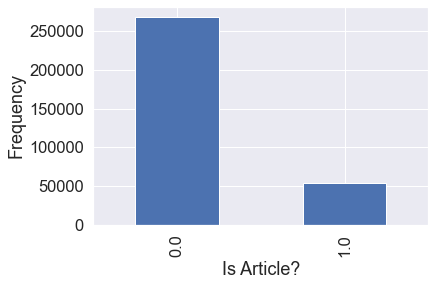

In [69]:
data.article.value_counts().plot.bar()
plt.xlabel("Is Article?")
plt.ylabel("Frequency")
plt.show()

In [25]:
data[data.article == 1].sample().shareLink.values[0]

'https://parler.com/post/9cf247d25fe04ed7a02db294b2faf827'

In [26]:
data[data.article == 0].sample().shareLink.values[0]

'https://parler.com/post/eab52177bf2f4f6695d512c58ad8887b'

Maybe it just means it's a link?

In [28]:
data[data.article == 1].nr_links.value_counts()

1    50601
2     1637
5      638
4      363
3      311
Name: nr_links, dtype: int64

It looks like if it's an article, it needs to have a link

In [29]:
data[data.article == 0].nr_links.value_counts()

0    141385
1    118231
2      5603
3      1119
5       790
4       703
Name: nr_links, dtype: int64

But it could be not an article and contain a link... Perhaps this is a way they distinguish between something be a piece of news?

In [30]:
data[(data.article == 0) & (data.nr_links == 1)].sample().shareLink.values[0]

'https://parler.com/post/d3a35b583c0e4d018141935ef29e0255'

Inconclusive for now. Will move on and reconsider if needed.

### What is depth?

In [79]:
data.depth.value_counts().head(20)

0     205576
1     103178
2       9792
3       1700
4        455
5        161
6         84
7         47
8         27
10        17
9         10
11         9
12         9
14         8
13         8
15         7
16         7
17         6
18         6
30         6
Name: depth, dtype: int64

In [71]:
data.depth.describe()

count    321393.000000
mean          0.471809
std           2.420645
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         165.000000
Name: depth, dtype: float64

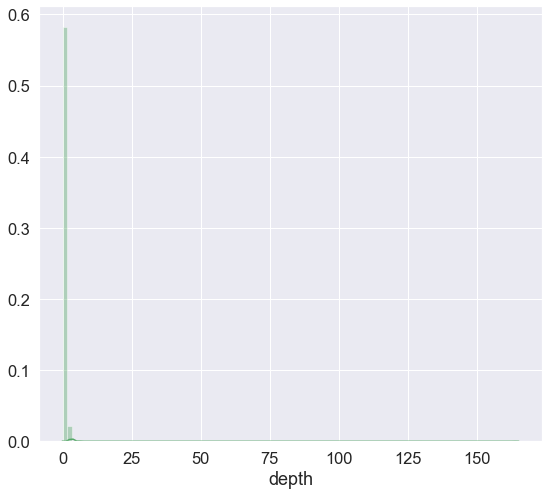

In [74]:
plt.figure(figsize=(9, 8))
sns.distplot(data['depth'], color='g', bins=100, hist_kws={'alpha': 0.4});

So mostly depth of 0. Let's see this max thing.

In [80]:
data[data.depth == 165].shareLink.values[0]

'https://parler.com/post/a91706b2955140fa88b6df84b7c050e1'

Actually that's not telling me much. Maybe this is a way to determine if something is an echo?

In [82]:
data[data.depth == 0].sample().shareLink.values[0]

'https://parler.com/post/0c6e5a2c74f440c7ba23f2ae7cfb5a1e'

In [85]:
data[data.depth == 1].sample().shareLink.values[0]

'https://parler.com/post/7753b706163f441995689d61e89c58ba'

Yup, looked at 5 on both sides, depth > 0 seems to indicate this is an echo.

In [88]:
data['isEcho'] = np.where(data['depth'] == 0, False, True)

In [90]:
data.isEcho.value_counts()

False    205576
True     115817
Name: isEcho, dtype: int64

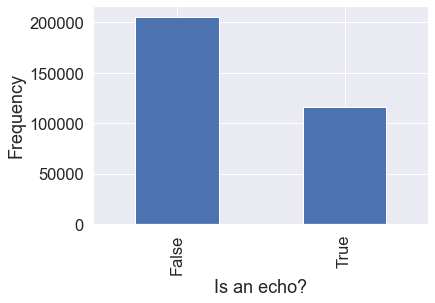

In [91]:
data.isEcho.value_counts().plot.bar()
plt.xlabel("Is an echo?")
plt.ylabel("Frequency")
plt.show()

So we have about 2:1 ratio of not echos to echos. Is 'parent' field telling us what it is an echo of?

In [93]:
data[data.parent.notna()].shape

(115817, 43)

Bingo?

In [94]:
data[(data.parent.notna()) & (data.isEcho == False)].shape

(0, 43)

Bingo??

In [96]:
data[data.isEcho == True].sample()

,post_id,body,post_date,article,depth,links,shareLink,sensitive,parent,root,creator_id,creator_bio,creator_coverPhoto,creator_human,creator_integration,creator_joined,creator_name,creator_rss,creator_profilePhoto,creator_username,creator_verified,creator_verifiedComments,creator_interactions,creator_state,creator_score,hashtags,nr_hashtags,nr_mentions,comments,impressions,reposts,upvotes,creator_badge_0,creator_badge_1,creator_badge_2,creator_badge_3,creator_badge_4,creator_badge_5,creator_badge_6,creator_badge_7,creator_badge_9,nr_links,isEcho
76087,e3396ee0b15e454bad482df1ced95ab5,#StopTheSteal,2020-11-22 21:12:04,0.0,2,[],https://parler.com/post/e3396ee0b15e454bad482d...,False,"{'_id': 'e53a1f9838074cd882fa655dc56f29b3', '@...","{'_id': '885fe25aae724db8a01ce8811d1ee6a9', '@...",3422e512cdcb4895ab586bdff5f3da83,"Life long conservative, retired from paper ind...",NaN,False,False,2020-06-13 21:49:40,Trf85373,False,NaN,Trf85373,False,False,258,NaN,55,stopthesteal,1,0,0,49,0,0,False,False,False,False,False,False,False,False,False,0,True


In [98]:
data.iloc[76087].parent

"{'_id': 'e53a1f9838074cd882fa655dc56f29b3', '@': {'sidneypowell': 'fd4eaf2436164605b291ba98e7061d7b', 'linwood': '2ea66900ed69a5005fe51fc8b07a1711', 'dineshdsouza': '27e957738eef23c55a3214d1b1154fbd', 'mariabartiromotv': 'cd346addd6534b43adc2a06a572ce0f5', 'marklevinshow': '34968cde93e74071990f927980baa2d9', 'mrsnerdley': '256857a6328f4181acaff40640851871'}, 'article': False, 'body': 'There will be a day soon when we come to the end and the light we see will be the light of truth.\\n\\n@SidneyPowell \\n@linwood \\n@DineshDSouza \\n#NeverQuit\\n#digitalsoldiers \\n#fightbackamerica \\n@Mariabartiromotv \\n@Marklevinshow \\n@MrSnerdley', 'comments': '1.4k', 'createdAt': '20201122204712', 'creator': '89e43877e52645a1bf8239d8a4fa2ac2', 'depth': '1', 'depthRaw': 1, 'hashtags': ['neverquit', 'digitalsoldiers', 'fightbackamerica'], 'id': 'e53a1f9838074cd882fa655dc56f29b3', 'impressions': '1.1m', 'links': [], 'parent': '885fe25aae724db8a01ce8811d1ee6a9', 'preview': 'There will be a day soon w

In [99]:
data.iloc[76087].shareLink

'https://parler.com/post/e3396ee0b15e454bad482df1ced95ab5'

Yup. Parent tells us about the post that the person echoed.

TODO extract features.

### What is root?

In [104]:
data[data.root.notna()].shape

(12639, 43)

I wonder if root is the main parly that has started the chain of echoes?

In [105]:
data[data.root.notna()].isEcho.value_counts()

True    12639
Name: isEcho, dtype: int64

In [107]:
data[data.root.notna()].depth.value_counts().head(10)

2     9792
3     1700
4      455
5      161
6       84
7       47
8       27
10      17
9       10
12       9
Name: depth, dtype: int64

Ah good, so no depth = 1, suggesting that yes, it might be.

In [109]:
data[data.depth == 3].sample()

,post_id,body,post_date,article,depth,links,shareLink,sensitive,parent,root,creator_id,creator_bio,creator_coverPhoto,creator_human,creator_integration,creator_joined,creator_name,creator_rss,creator_profilePhoto,creator_username,creator_verified,creator_verifiedComments,creator_interactions,creator_state,creator_score,hashtags,nr_hashtags,nr_mentions,comments,impressions,reposts,upvotes,creator_badge_0,creator_badge_1,creator_badge_2,creator_badge_3,creator_badge_4,creator_badge_5,creator_badge_6,creator_badge_7,creator_badge_9,nr_links,isEcho
70655,4e641da7b01b4f1d9f3b54d445d32312,Sidney Powell represents me! \n#fullconfindenc...,2020-11-23 13:12:30,0.0,3,[],https://parler.com/post/4e641da7b01b4f1d9f3b54...,False,"{'_id': '32e368e4b5b341219e73a20627c5634a', '@...","{'_id': '27f49f0a87bf416eac989e553272afce', '@...",5bf6400fee11472eb3d8fee462816764,Seeker of the truth,fadc0625339b4b53a65b5a42aab236d1,False,False,2020-02-19 07:15:55,Big Mike Media,False,88c446c3d5b04479a323a6dcfd6df344,BiGMIKEmedia,False,False,259,NaN,57,"fullconfindence, stopthesteal",2,0,0,67,0,0,False,False,False,False,False,False,False,False,False,0,True


In [110]:
data.iloc[70655].parent

"{'_id': '32e368e4b5b341219e73a20627c5634a', '@': {}, 'article': False, 'body': 'Thank you Sidney Powell for representing me!!! \\n#fraud #Treason #stopthesteal', 'comments': '0', 'createdAt': '20201123111837', 'creator': '25592f318ab848f5b25c59e9e59e1dc8', 'depth': '2', 'depthRaw': 2, 'hashtags': ['fraud', 'treason', 'stopthesteal'], 'id': '32e368e4b5b341219e73a20627c5634a', 'impressions': '394', 'links': [], 'preview': 'Thank you Sidney Powell for representing me!!! \\n#fraud #Treason #stopthesteal', 'reposts': '6', 'root': '27f49f0a87bf416eac989e553272afce', 'shareLink': 'https://parler.com/post/32e368e4b5b341219e73a20627c5634a', 'sensitive': False, 'state': 4, 'upvotes': '9'}"

In [111]:
data.iloc[70655].root

"{'_id': '27f49f0a87bf416eac989e553272afce', '@': {}, 'article': False, 'body': 'Sidney Powell represents me. \\n\\nKeep it going.', 'comments': '323', 'createdAt': '20201123045951', 'creator': '825ee061818e87be763f3853af245c7e', 'depth': '0', 'depthRaw': 0, 'hashtags': [], 'id': '27f49f0a87bf416eac989e553272afce', 'impressions': '540k', 'links': [], 'preview': 'Sidney Powell represents me. \\n\\nKeep it going.', 'reposts': '2.2k', 'shareLink': 'https://parler.com/post/27f49f0a87bf416eac989e553272afce', 'sensitive': False, 'state': 4, 'upvotes': '3.7k'}"

In [112]:
data.iloc[70655].shareLink

'https://parler.com/post/4e641da7b01b4f1d9f3b54d445d32312'

Yup, it works for depth = 3. What about depth = 4?

In [113]:
data[data.depth == 4].sample()

,post_id,body,post_date,article,depth,links,shareLink,sensitive,parent,root,creator_id,creator_bio,creator_coverPhoto,creator_human,creator_integration,creator_joined,creator_name,creator_rss,creator_profilePhoto,creator_username,creator_verified,creator_verifiedComments,creator_interactions,creator_state,creator_score,hashtags,nr_hashtags,nr_mentions,comments,impressions,reposts,upvotes,creator_badge_0,creator_badge_1,creator_badge_2,creator_badge_3,creator_badge_4,creator_badge_5,creator_badge_6,creator_badge_7,creator_badge_9,nr_links,isEcho
260118,28d738105bb4441895548c1ca07ffd3e,#stopthesteal,2020-11-10 02:10:24,0.0,4,[],https://parler.com/post/28d738105bb4441895548c...,False,"{'_id': 'b54a7b5b709c4d5a82abc92ff3730ad8', '@...","{'_id': '567f39b22e5d484a9b2fce0e5991cc38', '@...",91508edd98334ef58bcb28cbea8443df,NaN,197dda400fa542f9893a71a6f7044634,False,False,2020-07-07 12:52:57,Lisa Mckenna,False,5bd4fbc59e294ccca050771570bdf77f,Lisa4569,False,False,130,NaN,40,stopthesteal,1,0,0,110,0,1,False,False,False,False,False,False,False,False,False,0,True


In [114]:
data.iloc[260118].root

"{'_id': '567f39b22e5d484a9b2fce0e5991cc38', '@': {}, 'article': False, 'body': '2 guys at a wedding in Vegas find a bunch of Trump ballots in the garbage. \\n\\n#nevada\\n#stopthesteal\\n#attemptedcoup', 'comments': '429', 'createdAt': '20201109172353', 'creator': 'ea5548d2b27a47d5a118a954ac4a41af', 'depth': '0', 'depthRaw': 0, 'hashtags': ['nevada', 'stopthesteal', 'attemptedcoup'], 'id': '567f39b22e5d484a9b2fce0e5991cc38', 'impressions': '338k', 'links': ['EzCJnHGJEuTC'], 'preview': '2 guys at a wedding in Vegas find a bunch of Trump ballots in the garbage. \\n\\n#nevada\\n#stopthesteal\\n#attemptedcoup', 'reposts': '2.9k', 'shareLink': 'https://parler.com/post/567f39b22e5d484a9b2fce0e5991cc38', 'sensitive': False, 'state': 4, 'upvotes': '2.6k'}"

In [115]:
data.iloc[260118].shareLink

'https://parler.com/post/28d738105bb4441895548c1ca07ffd3e'

Yes, root is telling us what the original parlie was

### What is sensitive?

In [92]:
data.sensitive.value_counts()

False    321393
Name: sensitive, dtype: int64

Interesting. And useless.

### How many people have a cover photo?

In [125]:
print('Number of users without cover photo: ', len(data[data.creator_coverPhoto.isna()].creator_id.unique()))

Number of users without cover photo:  16734


In [126]:
print('Number of users with cover photo: ', len(data[~data.creator_coverPhoto.isna()].creator_id.unique()))

Number of users with cover photo:  28206


In [127]:
print('Total number of users: ', len(data.creator_id.unique()))

Total number of users:  44909


In [124]:
28206+16734

44940

This doesn't quite add up, but that's probably because some people might not have had a picture, and now they do - or vice versa. Close enough for now.

### does everyone have a bio?

In [129]:
print('Number of users without bio: ', len(data[data.creator_bio.isna()].creator_id.unique()))

Number of users without bio:  15086


In [130]:
print('Number of users with bio: ', len(data[~data.creator_bio.isna()].creator_id.unique()))

Number of users with bio:  29863


In [131]:
15086+29863

44949

Again, close enough.

### Is creator human

In [132]:
data.creator_human.value_counts()

False    184265
True     137128
Name: creator_human, dtype: int64

In [134]:
data[data.creator_human].shape

(137128, 43)

I wonder if any of the badges mean the same thing?

In [135]:
data[data.creator_human].creator_badge_0.value_counts()

True    137128
Name: creator_badge_0, dtype: int64

In [136]:
data[data.creator_human].creator_badge_1.value_counts()

False    136540
True        588
Name: creator_badge_1, dtype: int64

In [137]:
data[data.creator_human].creator_badge_3.value_counts()

False    137068
True         60
Name: creator_badge_3, dtype: int64

In [138]:
data[data.creator_human].creator_badge_4.value_counts()

False    136940
True        188
Name: creator_badge_4, dtype: int64

In [139]:
data[data.creator_human].creator_badge_5.value_counts()

False    131983
True       5145
Name: creator_badge_5, dtype: int64

In [140]:
data[data.creator_human].creator_badge_6.value_counts()

False    137123
True          5
Name: creator_badge_6, dtype: int64

In [141]:
data[data.creator_human].creator_badge_7.value_counts()

False    137125
True          3
Name: creator_badge_7, dtype: int64

In [142]:
data[data.creator_human].creator_badge_9.value_counts()

False    136471
True        657
Name: creator_badge_9, dtype: int64

Ok so maybe badge 0. But are there "non humans" with badge 0?

In [143]:
data[~data.creator_human].creator_badge_0.value_counts()

False    184265
Name: creator_badge_0, dtype: int64

So creator_human and badge 0 seem to be the same thing.

### creator integration? what on earth?

In [145]:
data.creator_integration.value_counts()

False    321378
True         15
Name: creator_integration, dtype: int64

So only 4 users have this flag - LauraLoomer, DailyDefender, epochtimes, and milnenews. They all have badges 2, but don't have badges 4, 5, 6, 7. I have no idea what this means.

In [169]:
data.creator_badge_2.value_counts()

False    321378
True         15
Name: creator_badge_2, dtype: int64

Creator integration might be creator badge 2

### Creator RSS?

In [147]:
data.creator_rss.value_counts()

False    321320
True         73
Name: creator_rss, dtype: int64

### Creator verified?

In [148]:
data.creator_verified.value_counts()

False    320418
True        975
Name: creator_verified, dtype: int64

In [149]:
data[data.creator_verified].creator_badge_0.value_counts()

True     588
False    387
Name: creator_badge_0, dtype: int64

In [150]:
data[data.creator_verified].creator_badge_1.value_counts()

True    975
Name: creator_badge_1, dtype: int64

In [152]:
data[data.creator_verified].creator_badge_2.value_counts()

False    971
True       4
Name: creator_badge_2, dtype: int64

In [153]:
data[data.creator_verified].creator_badge_3.value_counts()

False    958
True      17
Name: creator_badge_3, dtype: int64

In [154]:
data[data.creator_verified].creator_badge_4.value_counts()

False    975
Name: creator_badge_4, dtype: int64

In [155]:
data[data.creator_verified].creator_badge_5.value_counts()

False    975
Name: creator_badge_5, dtype: int64

In [156]:
data[data.creator_verified].creator_badge_6.value_counts()

False    975
Name: creator_badge_6, dtype: int64

In [157]:
data[data.creator_verified].creator_badge_7.value_counts()

False    975
Name: creator_badge_7, dtype: int64

In [159]:
data[data.creator_verified].creator_badge_9.value_counts()

False    955
True      20
Name: creator_badge_9, dtype: int64

Maybe Badge 1 means creator is verified?

In [160]:
data[~data.creator_verified].creator_badge_1.value_counts()

False    320418
Name: creator_badge_1, dtype: int64

Yeah, plausible.

### Creator verified comments?

In [161]:
data.creator_verifiedComments.value_counts()

False    314012
True       7381
Name: creator_verifiedComments, dtype: int64

In [167]:
data[data.creator_verifiedComments].creator_badge_5.value_counts()

True    7381
Name: creator_badge_5, dtype: int64

In [166]:
data.creator_badge_5.value_counts()

False    314012
True       7381
Name: creator_badge_5, dtype: int64

Ok, so verified comments might be badge 5.

### Creator interactions?

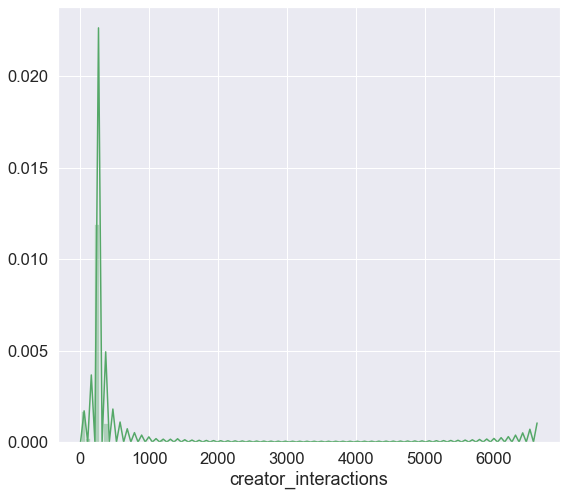

In [170]:
plt.figure(figsize=(9, 8))
sns.distplot(data['creator_interactions'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [171]:
data.creator_interactions.value_counts()

258     162080
259      81792
3        16781
2        16233
386      12528
266      10448
387       8491
130       2988
1154      2212
131       2194
10        2076
394       1258
291        664
1410       492
35         473
138        386
263         57
419         57
42          37
262         37
426         32
34          25
290         16
270         12
163          9
14           5
6147         4
6407         1
7            1
286          1
391          1
6146         1
6631         1
Name: creator_interactions, dtype: int64

Ok that is mega weird and who knows what it means.

TODO figure out what this means

### Creator state?

In [172]:
data.creator_state.value_counts()

1.0    141979
2.0      5132
5.0       244
Name: creator_state, dtype: int64

### Creator score

In [229]:
data.creator_score.describe()

count    3.213930e+05
mean     1.044497e+04
std      6.632352e+04
min     -5.100000e+04
25%      3.370000e+02
50%      1.500000e+03
75%      5.700000e+03
max      3.500000e+06
Name: creator_score, dtype: float64

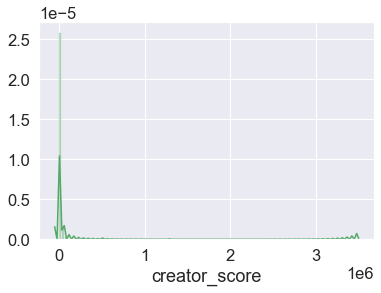

In [206]:
sns.distplot(data['creator_score'], color='g', bins=100, hist_kws={'alpha': 0.4});

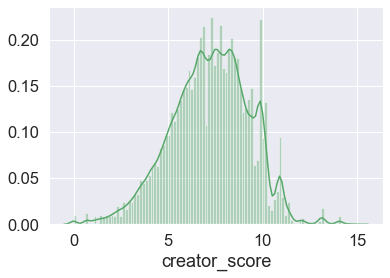

In [273]:
sns.distplot(np.log(data[data.creator_score > 0].creator_score), color='g', bins=100, hist_kws={'alpha': 0.4});

In [196]:
data[data.creator_score < 0].shape

(3213, 43)

In [197]:
data[data.creator_score > 0].shape

(317671, 43)

In [198]:
data[data.creator_score == 0].shape

(509, 43)

In [515]:
# create a list of our conditions
conditions = [
    (data['creator_score'] < 0),
    (data['creator_score'] > -1)
    ]

# create a list of the values we want to assign for each condition
values = ['negative', 'positive']

# create a new column and use np.select to assign values to it using our lists as arguments
data['reputation'] = np.select(conditions, values)

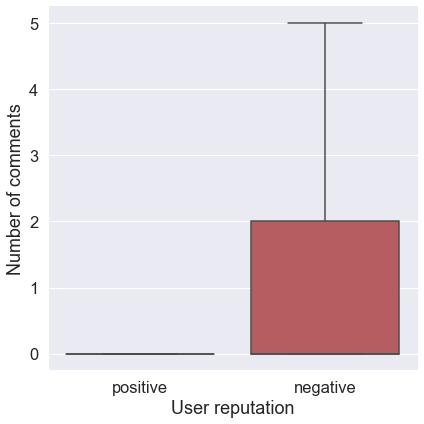

In [522]:
sns_plot = sns.catplot(x="reputation", y="comments", kind="box", 
                       data=data, showfliers = False,
                       height = 6, palette={'positive':'g', 'negative':'r'})
plt.xlabel("User reputation")
plt.ylabel("Number of comments")
plt.show()

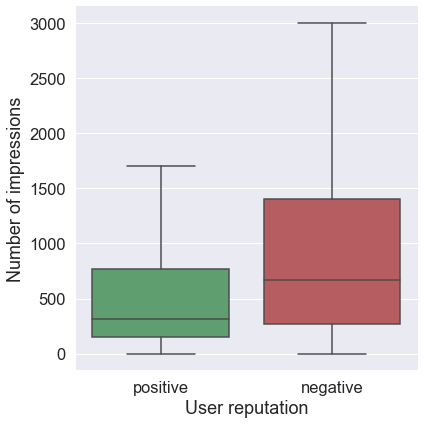

In [523]:
sns_plot = sns.catplot(x="reputation", y="impressions", kind="box", 
                       data=data, showfliers = False,
                       height = 6, palette={'positive':'g', 'negative':'r'})
plt.xlabel("User reputation")
plt.ylabel("Number of impressions")
plt.show()

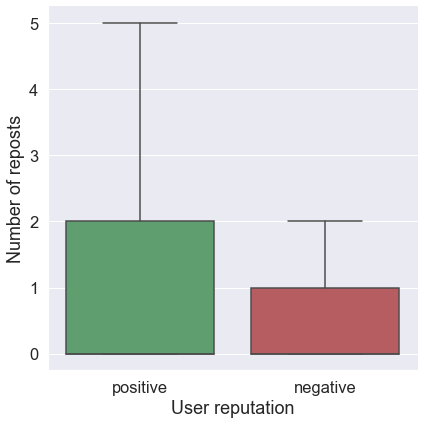

In [524]:
sns_plot = sns.catplot(x="reputation", y="reposts", kind="box", 
                       data=data, showfliers = False,
                       height = 6, palette={'positive':'g', 'negative':'r'})
plt.xlabel("User reputation")
plt.ylabel("Number of reposts")
plt.show()

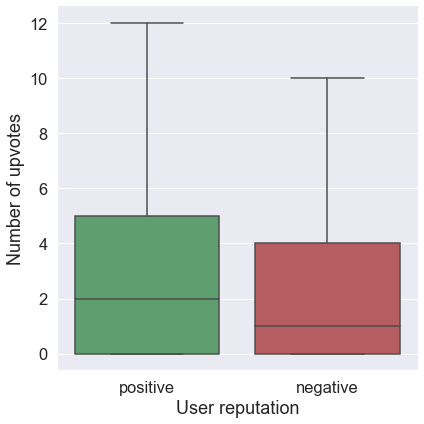

In [525]:
sns_plot = sns.catplot(x="reputation", y="upvotes", kind="box", 
                       data=data, showfliers = False,
                       height = 6, palette={'positive':'g', 'negative':'r'})
plt.xlabel("User reputation")
plt.ylabel("Number of upvotes")
plt.show()

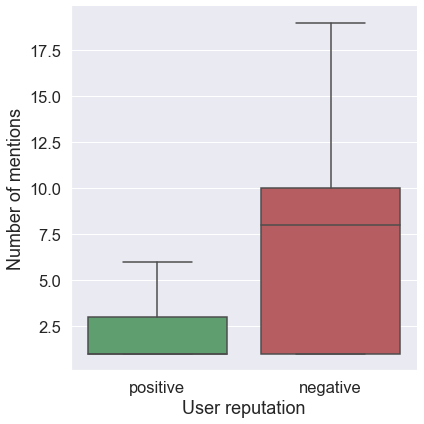

In [527]:
sns_plot = sns.catplot(x="reputation", y="nr_mentions", kind="box", 
                       data=data[data.nr_mentions > 0], showfliers = False,
                       height = 6, palette={'positive':'g', 'negative':'r'})
plt.xlabel("User reputation")
plt.ylabel("Number of mentions")
plt.show()

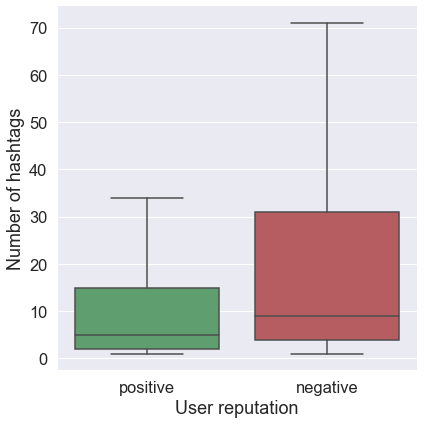

In [532]:
sns_plot = sns.catplot(x="reputation", y="nr_hashtags", kind="box", 
                       data=data, showfliers = False,
                       height = 6, palette={'positive':'g', 'negative':'r'})
plt.xlabel("User reputation")
plt.ylabel("Number of hashtags")
plt.show()

### number of hashtags per post

In [228]:
data.nr_hashtags.describe()

count    321393.000000
mean         13.324329
std          18.390176
min           1.000000
25%           2.000000
50%           5.000000
75%          15.000000
max         116.000000
Name: nr_hashtags, dtype: float64

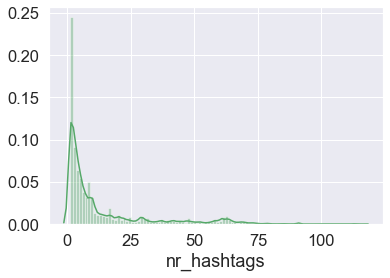

In [208]:
sns.distplot(data['nr_hashtags'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [209]:
data[data.nr_hashtags == 1].shape

(53573, 43)

In [210]:
data[data.nr_hashtags > 1].shape

(267820, 43)

### Number of mentions

In [227]:
data.nr_mentions.describe()

count    321393.000000
mean          0.344488
std           2.342442
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          80.000000
Name: nr_mentions, dtype: float64

In [213]:
print('Number of posts without mentions: ', data[data.nr_mentions == 0].shape[0])

Number of posts without mentions:  291925


In [215]:
print('Number of posts with mentions: ', data[data.nr_mentions > 0].shape[0])

Number of posts with mentions:  29468


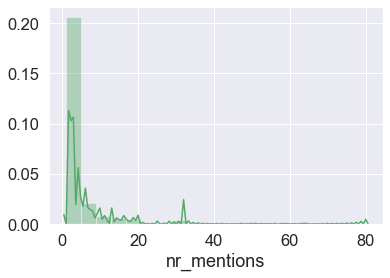

In [291]:
sns.distplot(data[data.nr_mentions > 0].nr_mentions, color='g', bins=20, hist_kws={'alpha': 0.4});

### Number of comments

In [225]:
data.comments.describe()

count    321393.000000
mean          1.317711
std          18.312612
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2800.000000
Name: comments, dtype: float64

In [219]:
print('Number of posts without comments: ', data[data.comments == 0].shape[0])

Number of posts without comments:  253521


In [220]:
print('Number of posts with comments: ', data[data.comments > 0].shape[0])

Number of posts with comments:  67872


In [223]:
print('Number of posts with 1 comment: ', data[data.comments == 1].shape[0])

Number of posts with 1 comment:  35045


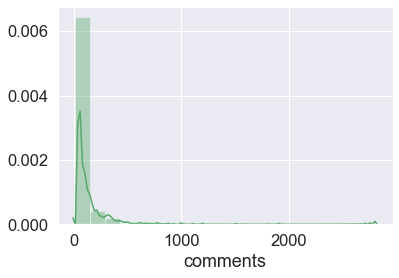

In [290]:
sns.distplot(data[data.comments > 10].comments, color='g', bins=20, hist_kws={'alpha': 0.4});

### Impressions

In [230]:
data.impressions.describe()

count    3.213930e+05
mean     1.411053e+03
std      2.454246e+04
min      0.000000e+00
25%      1.490000e+02
50%      3.220000e+02
75%      7.770000e+02
max      8.200000e+06
Name: impressions, dtype: float64

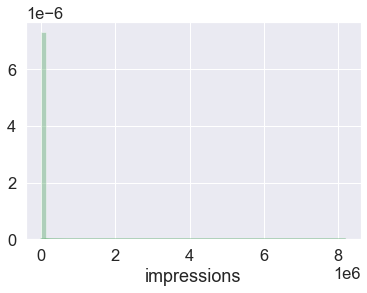

In [235]:
sns.distplot(data.impressions, color='g', bins=60, hist_kws={'alpha': 0.4});

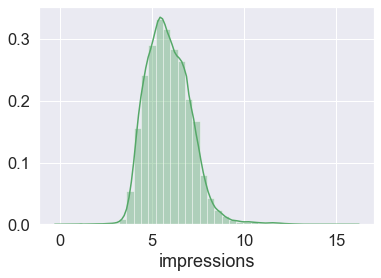

In [250]:
sns.distplot(np.log(data[data.impressions > 0].impressions), color='g', bins=40, hist_kws={'alpha': 0.4});

In [236]:
data[data.impressions < 10].shape

(227, 43)

In [237]:
data[data.impressions > 10000].shape

(3331, 43)

### Reposts

In [281]:
data.reposts.describe()

count    321393.000000
mean          6.152041
std          76.374814
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max        9100.000000
Name: reposts, dtype: float64

In [282]:
data[data.reposts == 0].shape

(168474, 43)

In [283]:
data[data.reposts != 0].shape

(152919, 43)

So about half and half re: how often they are echoed (reposted)

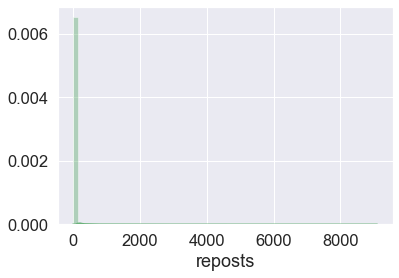

In [285]:
sns.distplot(data[data.reposts > 0].reposts, color='g', bins=60, hist_kws={'alpha': 0.4});

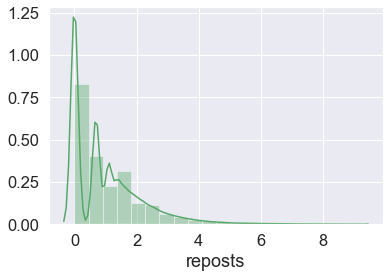

In [289]:
sns.distplot(np.log(data[data.reposts > 0].reposts), color='g', bins=20, hist_kws={'alpha': 0.4});

### Upvotes

In [292]:
data.upvotes.describe()

count    321393.000000
mean         13.269023
std         159.768757
min           0.000000
25%           0.000000
50%           2.000000
75%           5.000000
max       24000.000000
Name: upvotes, dtype: float64

In [294]:
print('Number of posts without any upvotes: ', data[data.upvotes == 0].shape[0])

Number of posts without any upvotes:  84097


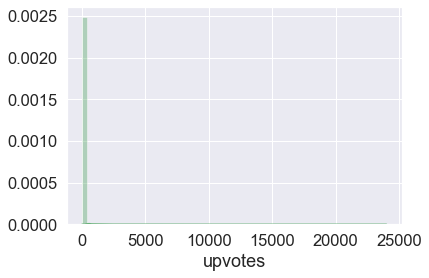

In [296]:
sns.distplot(data[data.upvotes > 0].upvotes, color='g', bins=60, hist_kws={'alpha': 0.4});

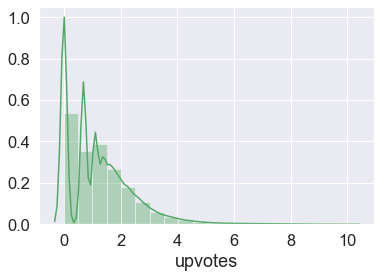

In [295]:
sns.distplot(np.log(data[data.upvotes > 0].upvotes), color='g', bins=20, hist_kws={'alpha': 0.4});

### exploring correlations between various numeric indicators of post success

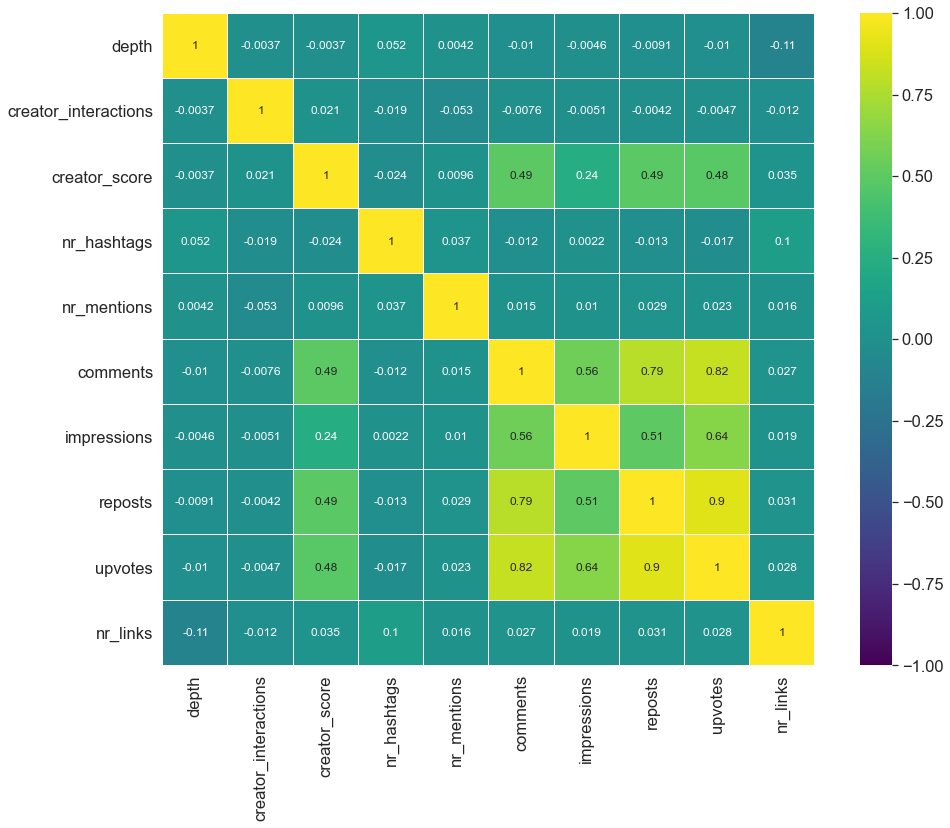

In [484]:
corr = data.select_dtypes(include = ['float64', 'int64']).drop(['article', 'creator_state'], axis=1).corr()
plt.figure(figsize=(16, 12))

sns.heatmap(corr, cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 12}, square=True);

### When have posts been made?

In [325]:
data.index = pd.to_datetime(data.post_date)

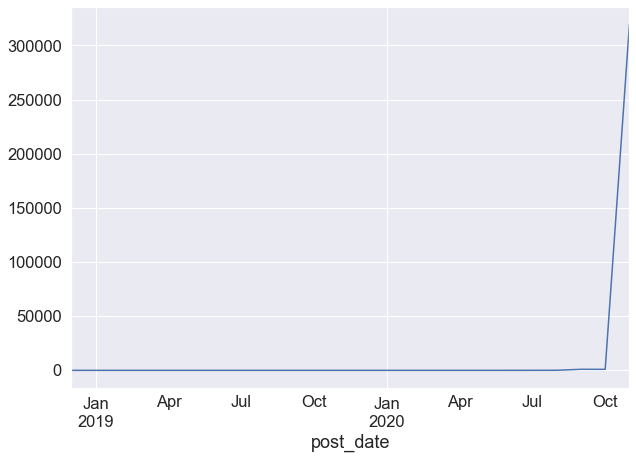

In [326]:
data.post_date.groupby(pd.Grouper(freq='M')).agg('count').plot(figsize=(10,7))

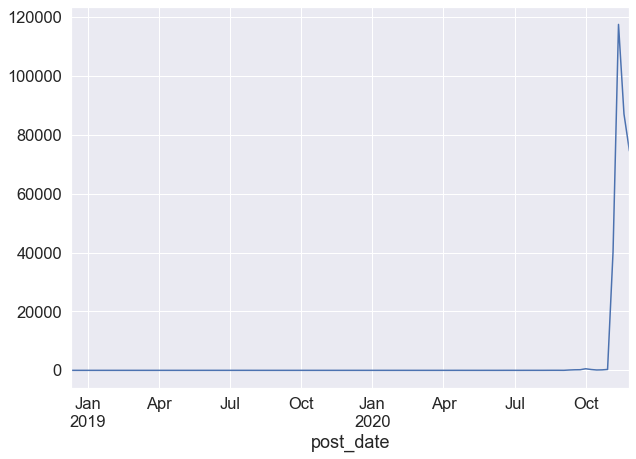

In [327]:
data.post_date.groupby(pd.Grouper(freq='W')).agg('count').plot(figsize=(10,7))

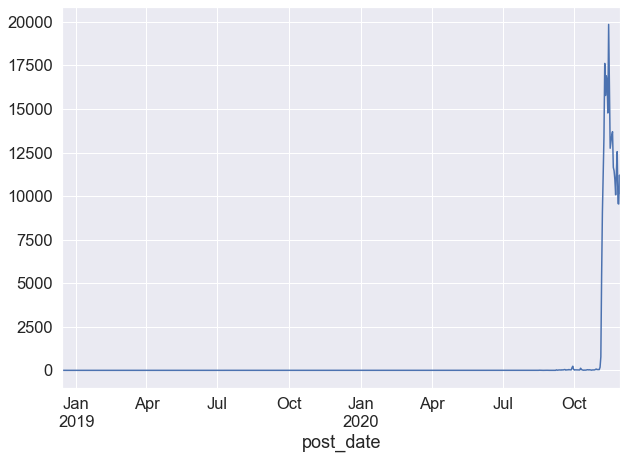

In [328]:
data.post_date.groupby(pd.Grouper(freq='D')).agg('count').plot(figsize=(10,7))

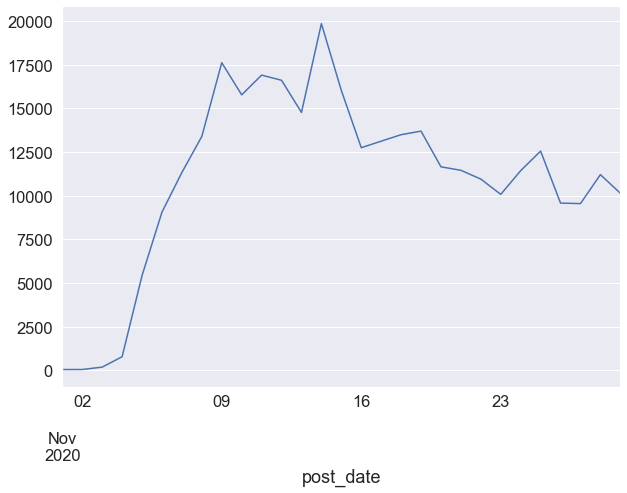

In [332]:
data[data.post_date > '2020-11-01'].post_date.groupby(pd.Grouper(freq='D')).agg('count').plot(figsize=(10,7))

In [333]:
print('Number of posts created before the election: ', data[data.post_date < '2020-11-03'].shape[0])

Number of posts created before the election:  2062


In [334]:
print('Number of posts created on or after the election: ', data[data.post_date >= '2020-11-03'].shape[0])

Number of posts created on or after the election:  319331


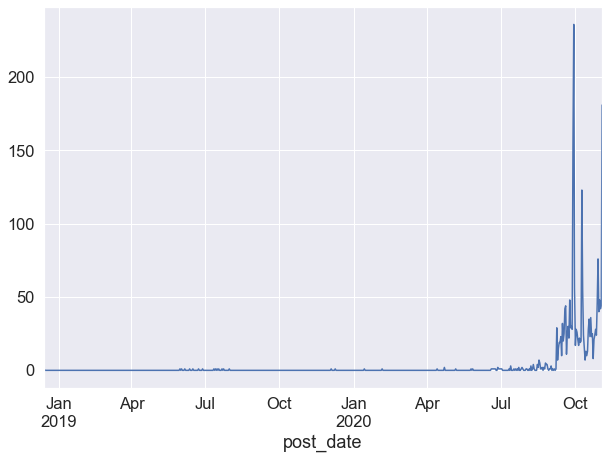

In [335]:
data[data.post_date < '2020-11-04'].post_date.groupby(pd.Grouper(freq='D')).agg('count').plot(figsize=(10,7))

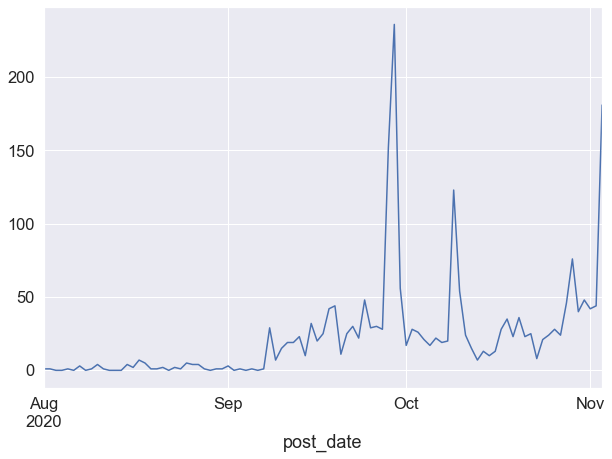

In [337]:
data[(data.post_date < '2020-11-04') & (data.post_date > '2020-08-01')].post_date.groupby(pd.Grouper(freq='D')).agg('count').plot(figsize=(10,7))

## Looking into users

### When did users join Parler, aggregated by month?

In [378]:
user_data.index = pd.to_datetime(user_data.creator_joined)

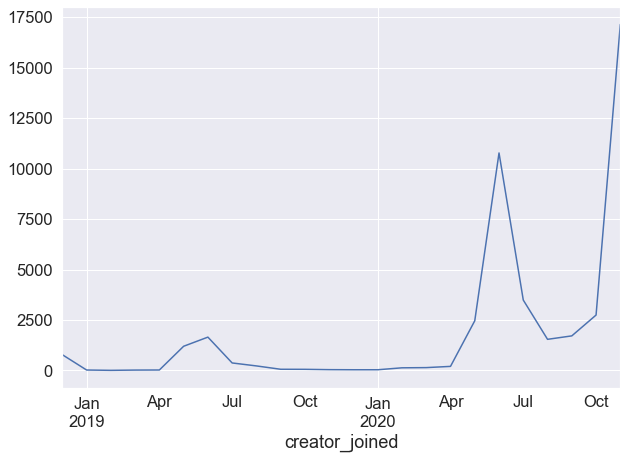

In [379]:
user_data.creator_joined.groupby(pd.Grouper(freq='M')).agg('count').plot(figsize=(10,7))

### When did users join Parler, aggregated by week?

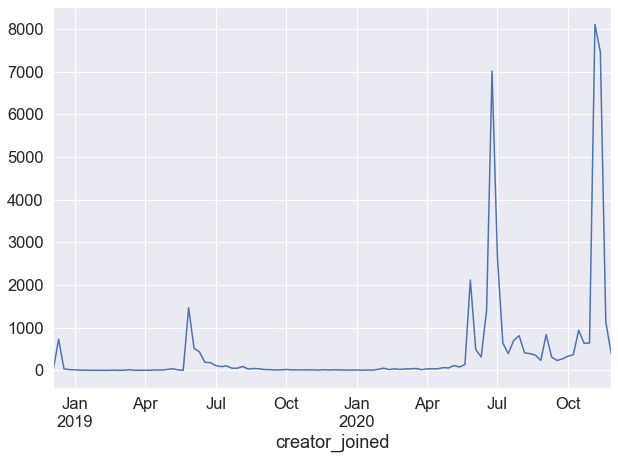

In [380]:
user_data.creator_joined.groupby(pd.Grouper(freq='W')).agg('count').plot(figsize=(10,7))

### When did users join Parler (zoom on 2020, agg by week)

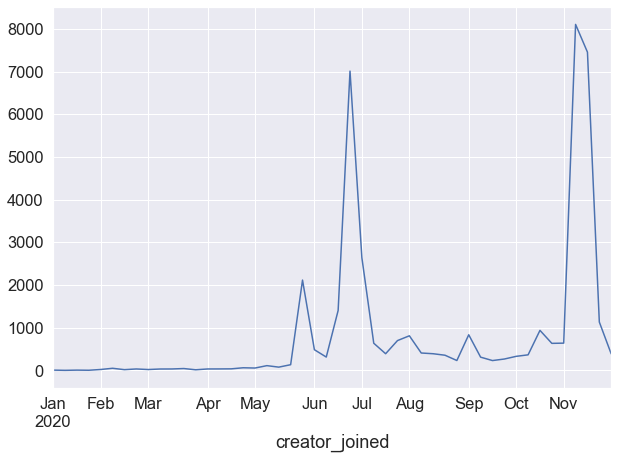

In [381]:
user_data[user_data.creator_joined > '2020-01-01'].creator_joined.groupby(pd.Grouper(freq='W')).agg('count').plot(figsize=(10,7))

### What are the weeks when most new users joined?

In [382]:
user_data.creator_joined.groupby(pd.Grouper(freq='W')).agg('count').sort_values(ascending=False).head(10)

creator_joined
2020-11-08    8105
2020-11-15    7455
2020-06-28    7011
2020-07-05    2640
2020-05-31    2117
2019-06-02    1467
2020-06-21    1405
2020-11-22    1134
2020-10-18     939
2020-09-06     836
Name: creator_joined, dtype: int64

### Getting info on mean activity for users

In [384]:
user_data.head()

,creator_id,creator_bio,creator_coverPhoto,creator_human,creator_integration,creator_joined,creator_name,creator_rss,creator_profilePhoto,creator_username,creator_verified,creator_verifiedComments,creator_interactions,creator_state,creator_score,creator_badge_0,creator_badge_1,creator_badge_2,creator_badge_3,creator_badge_4,creator_badge_5,creator_badge_6,creator_badge_7,creator_badge_9,nr_hashtags,nr_mentions,nr_links,mean_comments,mean_impressions,mean_reposts,mean_upvotes,nr_posts,nr_echos,echo_ratio
creator_joined,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-01 12:17:04,d8f57880bbd540e9a1e1bc89e46fdcef,"I am a patriot, and proud supporter of the bes...",f74d523f9d8e403f81f4587da9c24c4f,False,False,2020-10-01 12:17:04,Haley S.,False,82c3df8812b149ae87354125efdc6ccf,Absolutefusteration,False,False,258,1.0,117,False,False,False,False,False,False,False,False,False,3.185185,0.000000,0.037037,0.074074,108.370370,0.000000,0.703704,27,2,0.074074
2020-09-18 17:39:29,5ef511800e6e48d8b23e92d37467b718,Faith✝️Family👨‍👩‍👧‍👦America🦅Trump🇺🇸Freedom💪Pro...,12d5f5bf38834ea7b6613ba4081096eb,False,False,2020-09-18 17:39:29,Cascadefalls,False,0f077b2a7fa044e8a5f9e8856d04bdd6,Cascadefalls,False,False,258,1.0,3000,False,False,False,False,False,False,False,False,False,57.216667,0.001515,0.298485,0.224242,687.254545,0.922727,2.227273,660,464,0.703030
2020-11-07 21:07:29,765cdf14184243259ad5fddb71a854ce,The vote is our primary right upon which all o...,25dc373993c64e75a8001fbc2d316468,True,False,2020-11-07 21:07:29,Jack Jones,False,fda1bc735d4844baa88ada3ea62d549d,1965jackjones,False,False,3,1.0,1500,True,False,False,False,False,False,False,False,False,11.448000,0.032000,0.988000,0.140000,316.320000,0.688000,1.592000,250,5,0.020000
2020-11-08 22:20:23,a32f450ba92d4a9486b0fb1b94ee397f,All races were created equal by God!\n#trump2020,6c0f247a2d0b4fbea0ec51546fe63c94,True,False,2020-11-08 22:20:23,President Elect Poppakap,False,2a8c272773f249678cfa2cf758908944,Poppakap,False,False,259,1.0,2500,True,False,False,False,False,False,False,False,False,6.600000,0.050000,0.450000,0.525000,444.900000,1.225000,2.350000,40,20,0.500000
2020-11-24 18:40:03,2a5c8defed0648c49c0742a7582ac797,Judge Jeanine Pirro Fan Page,3d5b9bc72ee0463ba14a7b34c8a1e7db,False,False,2020-11-24 18:40:03,Judge Jeanine Pirro,False,d4968d0b26f643daae7d3bd3975687c6,judgejeaninepirrofanpage,False,False,258,1.0,1800,False,False,False,False,False,False,False,False,False,65.319149,0.007092,0.794326,1.617021,2006.255319,6.035461,9.177305,141,29,0.205674


In [485]:
df_num = user_data.select_dtypes(include = ['float64', 'int64'])
del df_num['creator_state']

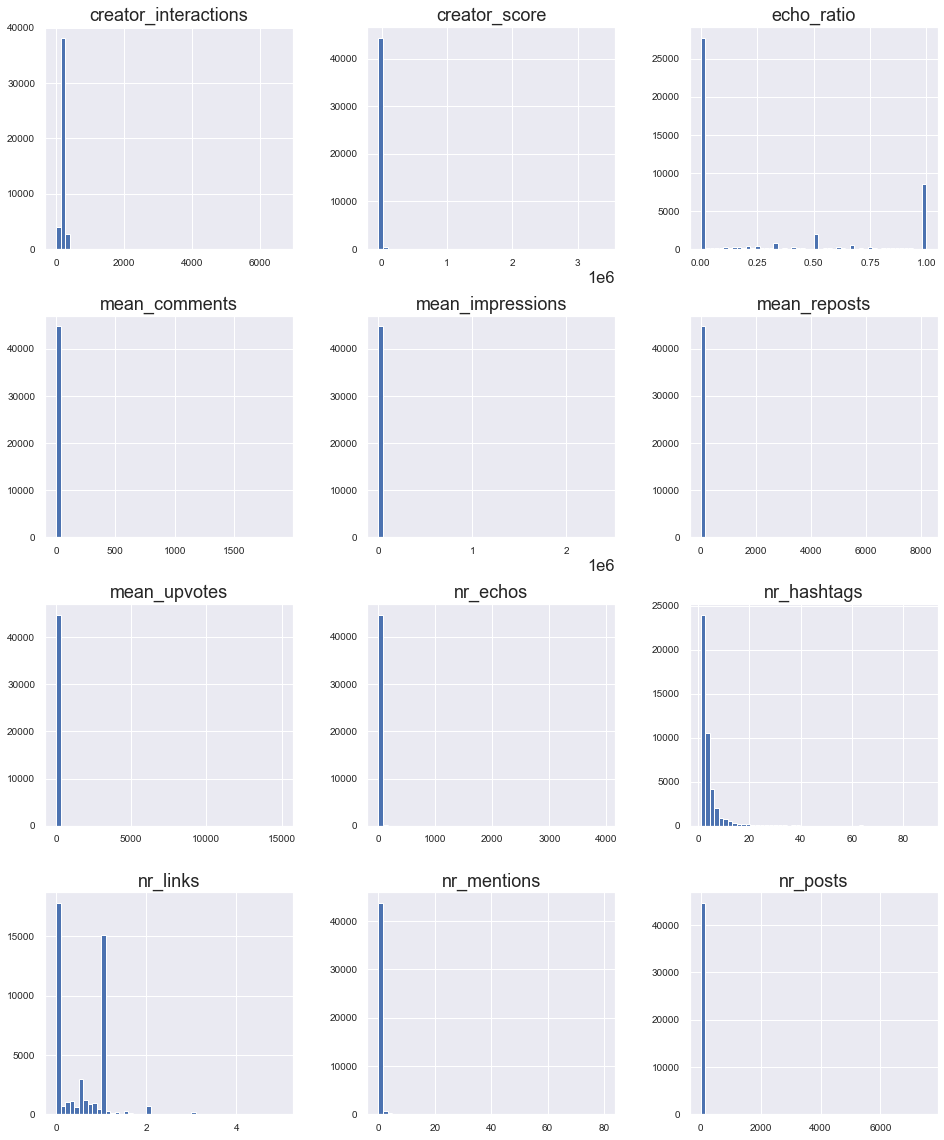

In [486]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=10, ylabelsize=10); # ;

In [487]:
df_num = df_num[['creator_interactions', 'nr_hashtags', 'nr_mentions',
       'nr_links', 'mean_comments', 'mean_impressions', 'mean_reposts',
       'mean_upvotes', 'nr_posts', 'nr_echos', 'echo_ratio', 'creator_score']]

In [488]:
df_num_corr = df_num.corr()['creator_score'][:-1] # -1 because the latest row is creator score
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with creator score:\n{}".format(len(golden_features_list), golden_features_list))

There is 1 strongly correlated values with creator score:
mean_comments    0.501129
Name: creator_score, dtype: float64


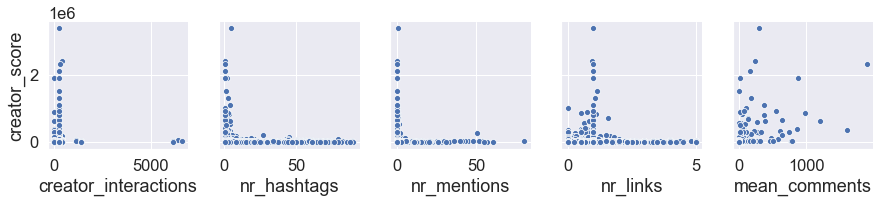

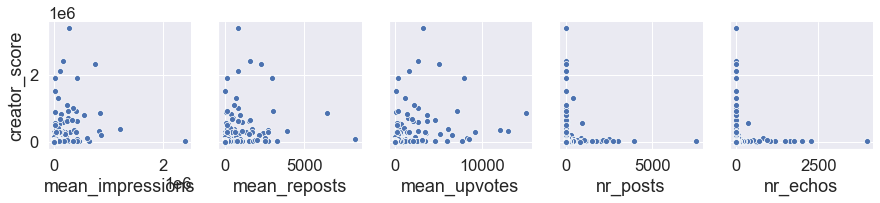

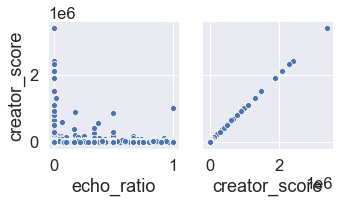

In [489]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['creator_score'])


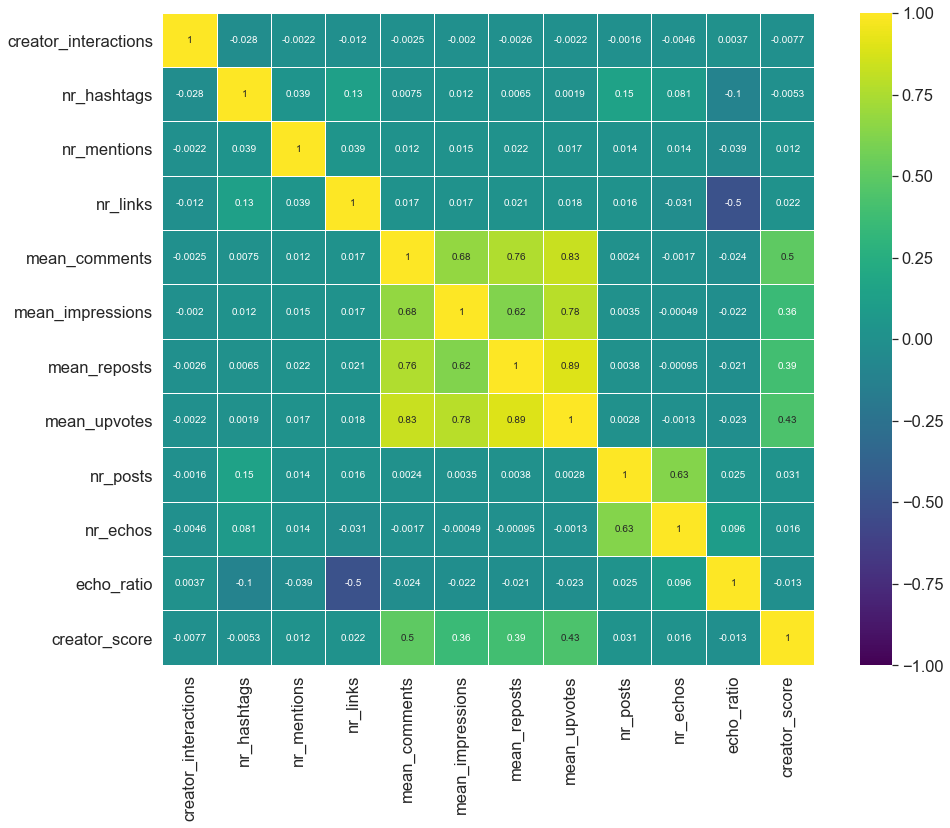

In [490]:
plt.figure(figsize=(16, 12))
sns.heatmap(df_num.corr(), 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 10}, square=True);


### Exploring whether users with positive vs negative reputation get different response

In [534]:
# determine if user has positive or negative reputation

# create a list of our conditions
conditions = [
    (user_data['creator_score'] < 0),
    (user_data['creator_score'] > -1)
    ]

# create a list of the values we want to assign for each condition
values = ['negative', 'positive']

# create a new column and use np.select to assign values to it using our lists as arguments
user_data['reputation'] = np.select(conditions, values)

In [549]:
print('Number of users with negative reputation : ', user_data[user_data.reputation == 'negative'].shape[0])
print('Number of users with positive reputation : ', user_data[user_data.reputation == 'positive'].shape[0])

Number of users with negative reputation :  541
Number of users with positive reputation :  44368


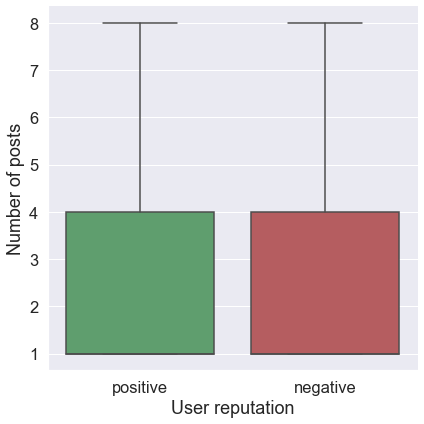

In [539]:
sns_plot = sns.catplot(x="reputation", y="nr_posts", kind="box", 
                       data=user_data, showfliers = False,
                       height = 6, palette={'positive':'g', 'negative':'r'})
plt.xlabel("User reputation")
plt.ylabel("Number of posts")
plt.show()

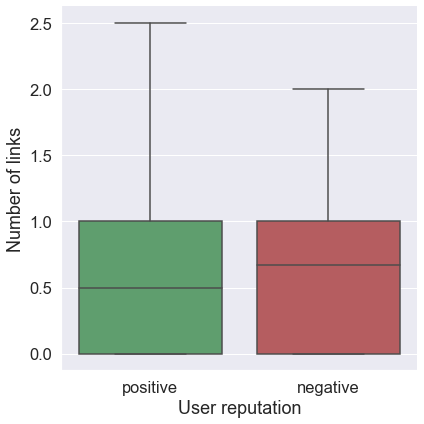

In [540]:
sns_plot = sns.catplot(x="reputation", y="nr_links", kind="box", 
                       data=user_data, showfliers = False,
                       height = 6, palette={'positive':'g', 'negative':'r'})
plt.xlabel("User reputation")
plt.ylabel("Number of links")
plt.show()

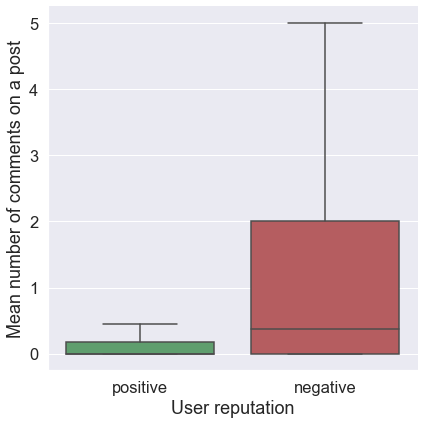

In [542]:
sns_plot = sns.catplot(x="reputation", y="mean_comments", kind="box", 
                       data=user_data, showfliers = False,
                       height = 6, palette={'positive':'g', 'negative':'r'})
plt.xlabel("User reputation")
plt.ylabel("Mean number of comments on a post")
plt.show()

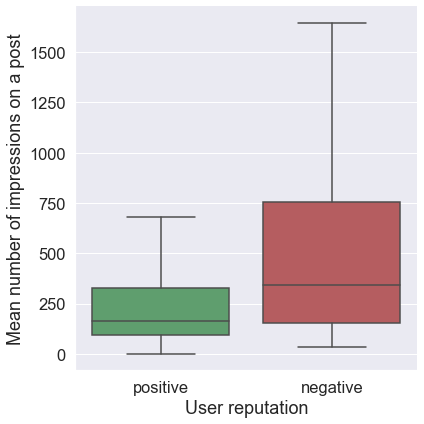

In [543]:
sns_plot = sns.catplot(x="reputation", y="mean_impressions", kind="box", 
                       data=user_data, showfliers = False,
                       height = 6, palette={'positive':'g', 'negative':'r'})
plt.xlabel("User reputation")
plt.ylabel("Mean number of impressions on a post")
plt.show()

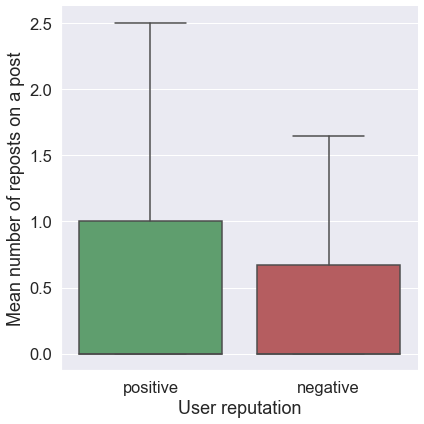

In [550]:
sns_plot = sns.catplot(x="reputation", y="mean_reposts", kind="box", 
                       data=user_data, showfliers = False,
                       height = 6, palette={'positive':'g', 'negative':'r'})
plt.xlabel("User reputation")
plt.ylabel("Mean number of reposts on a post")
plt.show()

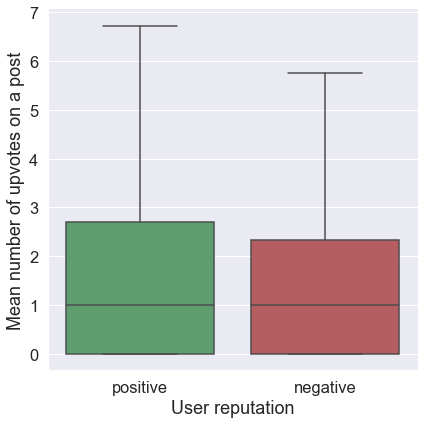

In [551]:
sns_plot = sns.catplot(x="reputation", y="mean_upvotes", kind="box", 
                       data=user_data, showfliers = False,
                       height = 6, palette={'positive':'g', 'negative':'r'})
plt.xlabel("User reputation")
plt.ylabel("Mean number of upvotes on a post")
plt.show()

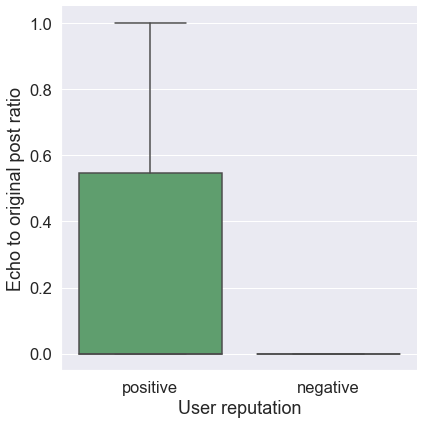

In [552]:
sns_plot = sns.catplot(x="reputation", y="echo_ratio", kind="box", 
                       data=user_data, showfliers = False,
                       height = 6, palette={'positive':'g', 'negative':'r'})
plt.xlabel("User reputation")
plt.ylabel("Echo to original post ratio")
plt.show()

In [553]:
user_data[user_data.reputation == 'negative'].echo_ratio.describe()

count    541.000000
mean       0.088102
std        0.248968
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: echo_ratio, dtype: float64

In [554]:
user_data[user_data.reputation == 'positive'].echo_ratio.describe()

count    44368.000000
mean         0.278984
std          0.405592
min          0.000000
25%          0.000000
50%          0.000000
75%          0.545455
max          1.000000
Name: echo_ratio, dtype: float64

### User reputation vs date of joining the platform

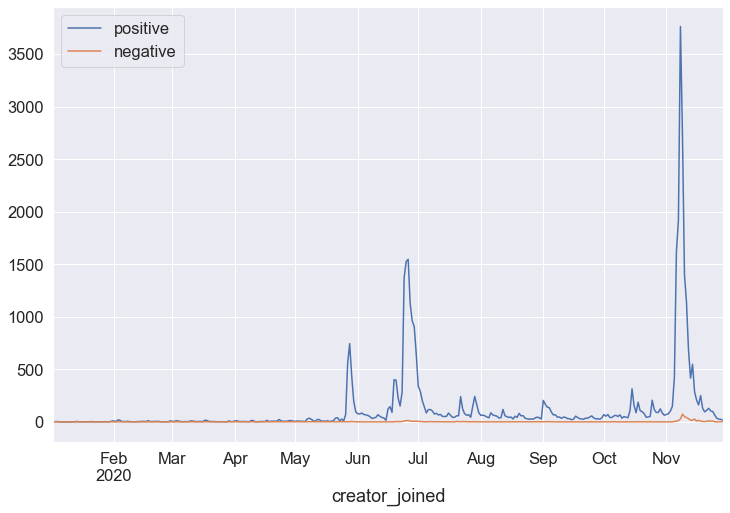

In [570]:
when_joined = user_data[user_data.reputation == 'positive'].creator_joined.groupby(pd.Grouper(freq='D')).agg('count')

when_joined = pd.concat([when_joined, user_data[user_data.reputation == 'negative'].creator_joined.groupby(pd.Grouper(freq='D')).agg('count')], axis=1)

when_joined.columns = ['positive', 'negative']

when_joined[when_joined.index > '2020-01-01'].plot(figsize=(12,8))

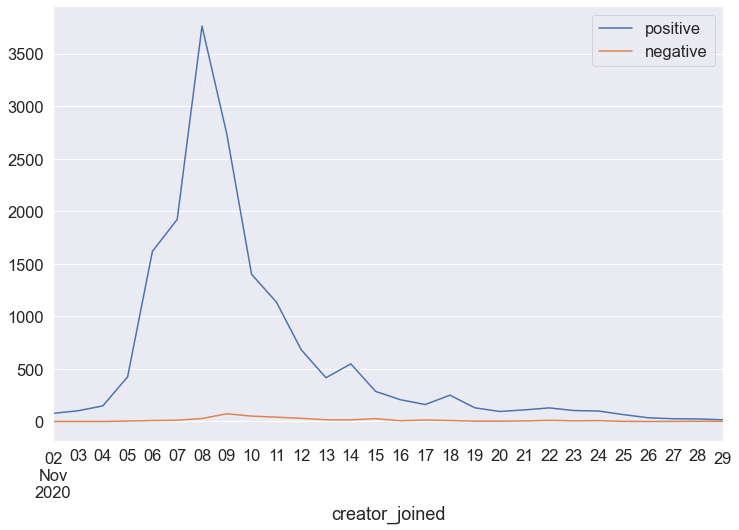

In [571]:
when_joined[when_joined.index > '2020-11-01'].plot(figsize=(12,8))

### Looking at some other binary variables

In [610]:
def boxplot_draw(var_x, desc_x, var_y, desc_y, data_in):
    plt.figure(figsize=(8,8))

    ax = sns.boxplot(x = var_x, y = var_y, 
                       data = data_in, showfliers = False, palette = {True:'g', False:'r'})
 
    # Calculate number of obs per group & median to position labels
    medians = data_in.groupby([var_x])[var_y].median().values
    nobs = data_in[var_x].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n = " + i for i in nobs]
 
    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos, ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] + 0.03, nobs[tick], 
            horizontalalignment='center', size='large', color='w', weight='semibold')

    plt.xlabel(desc_x)
    plt.ylabel(desc_y)
    plt.show()

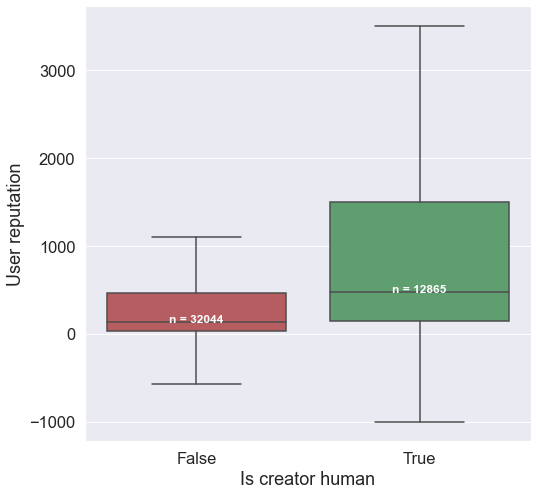

In [611]:
boxplot_draw('creator_human', 'Is creator human', 
             'creator_score', 'User reputation', user_data)

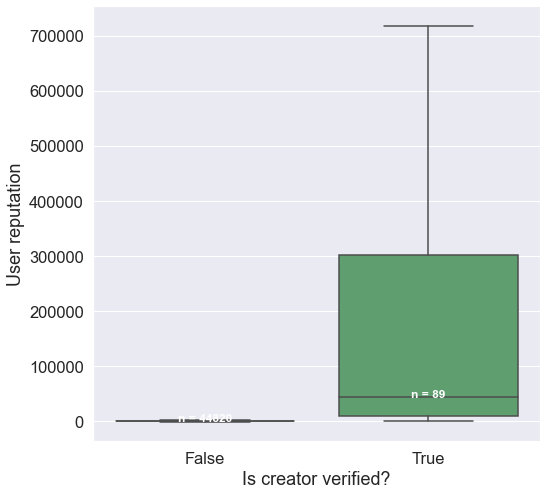

In [612]:
boxplot_draw('creator_verified', 'Is creator verified?', 
             'creator_score', 'User reputation', user_data)

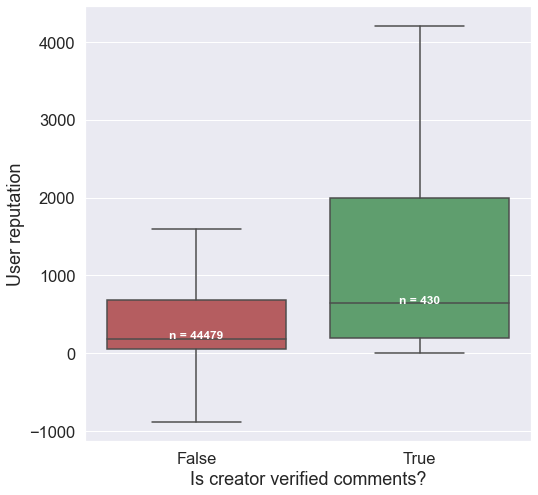

In [614]:
boxplot_draw('creator_verifiedComments', 'Is creator verified comments?', 
             'creator_score', 'User reputation', user_data)

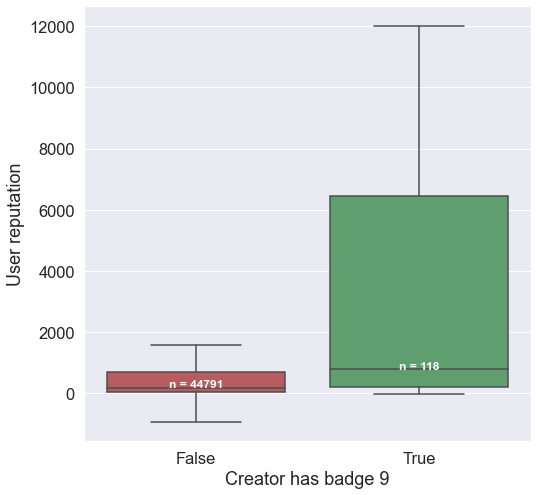

In [618]:
boxplot_draw('creator_badge_9', 'Creator has badge 9', 
             'creator_score', 'User reputation', user_data)

## Exploring hashtags

### What are the most frequently used hashtags?

In [452]:
hashtag_data['hashtag'].value_counts().head(30)

stopthesteal             321395
trump2020                111388
maga                      95840
trump                     58730
voterfraud                57854
electionfraud             52821
election2020              47418
wwg1wga                   43014
maga2020                  40430
trumptrain                37575
americafirst              36542
kag                       35371
kag2020                   32472
usa                       31956
donaldtrump               31234
draintheswamp             29180
fightback                 28323
parler                    28271
qanon                     28256
freedom                   26230
fakenews                  24871
dominion                  23572
patriots                  20262
keepamericagreat          19846
wakeupamerica             19737
deepstate                 19598
thegreatawakening         19498
conservative              19415
republican                18337
makeamericagreatagain     18256
Name: hashtag, dtype: int64

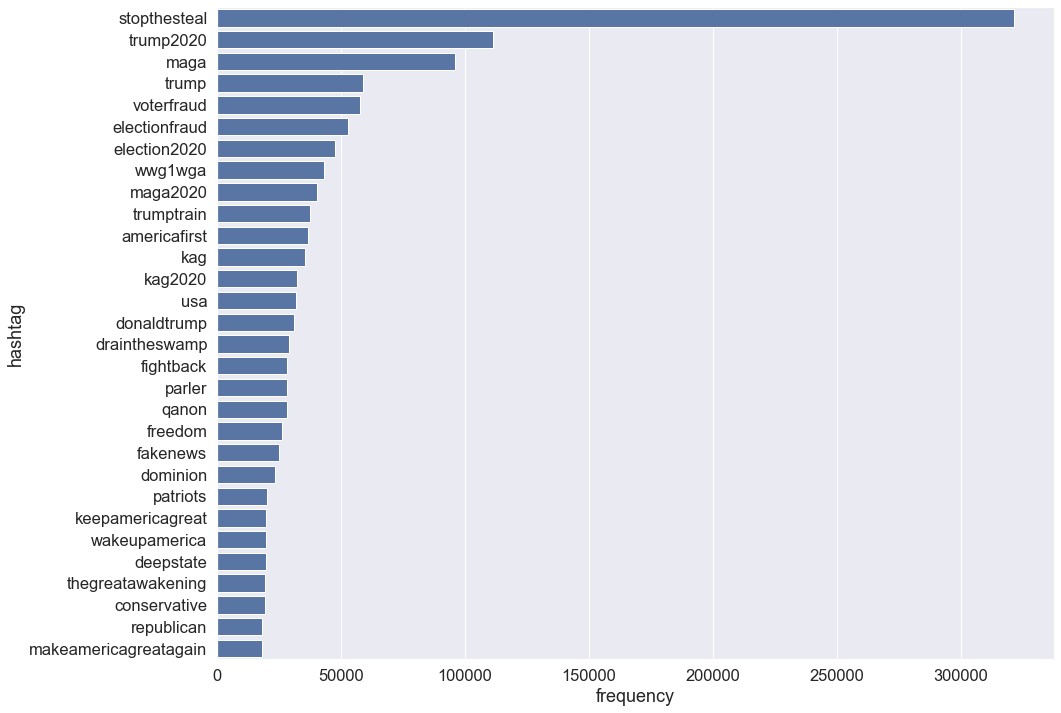

In [451]:
bar_plot_hash = hashtag_data['hashtag'].value_counts().head(30).to_frame()
bar_plot_hash.columns = ['frequency']
bar_plot_hash.index.names = ['hashtag']
bar_plot_hash.reset_index(level=0, inplace=True)

plt.figure(figsize=(15,12))
sns_plot = sns.barplot(y = 'hashtag', x = 'frequency', data = bar_plot_hash, color="b")


## how are hashtags used across time?

In [433]:
def plot_hashtags_over_time(hashtag_data, hashtags, frequency):
    
    summarised_data = hashtag_data[hashtag_data.hashtag == hashtags[0]].post_date.groupby(pd.Grouper(freq = frequency)).agg('count')
    
    for hashtag in hashtags[1:]:
        summarised_data = pd.concat([summarised_data, hashtag_data[hashtag_data.hashtag == hashtag].post_date.groupby(pd.Grouper(freq = frequency)).agg('count')], axis=1)
        
    summarised_data.columns = hashtags
    
    return summarised_data

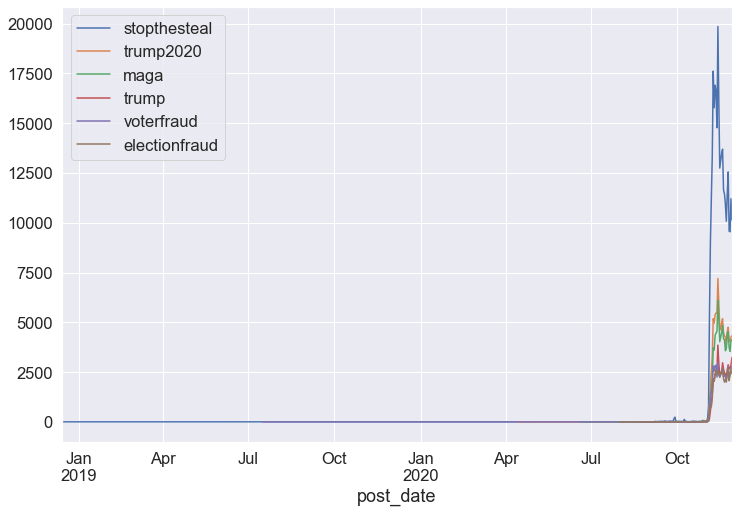

In [439]:
hashtags_to_plot = ['stopthesteal', 'trump2020', 'maga', 'trump', 'voterfraud', 'electionfraud']

frequency_binning = 'D'

res_df = plot_hashtags_over_time(hashtag_data, hashtags_to_plot, frequency_binning)

res_df.plot(figsize=(12,8))

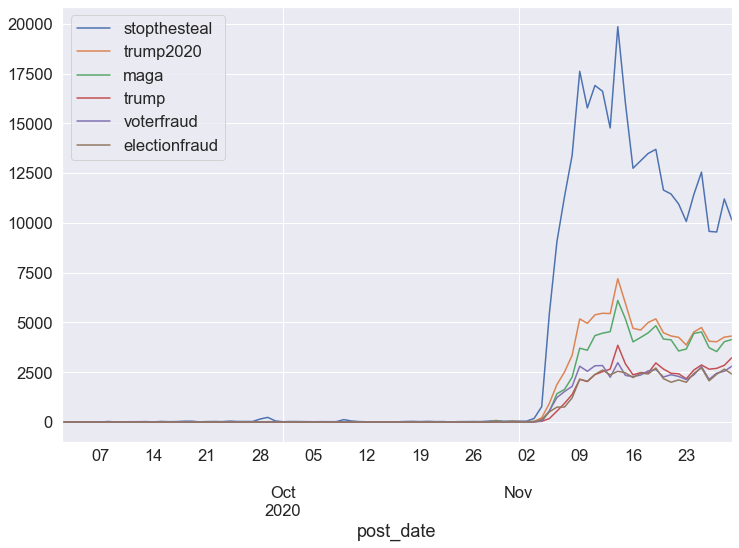

In [440]:
hashtags_to_plot = ['stopthesteal', 'trump2020', 'maga', 'trump', 'voterfraud', 'electionfraud']

frequency_binning = 'D'

res_df = plot_hashtags_over_time(hashtag_data, hashtags_to_plot, frequency_binning)

res_df[res_df.index > '2020-09-01'].plot(figsize=(12,8))

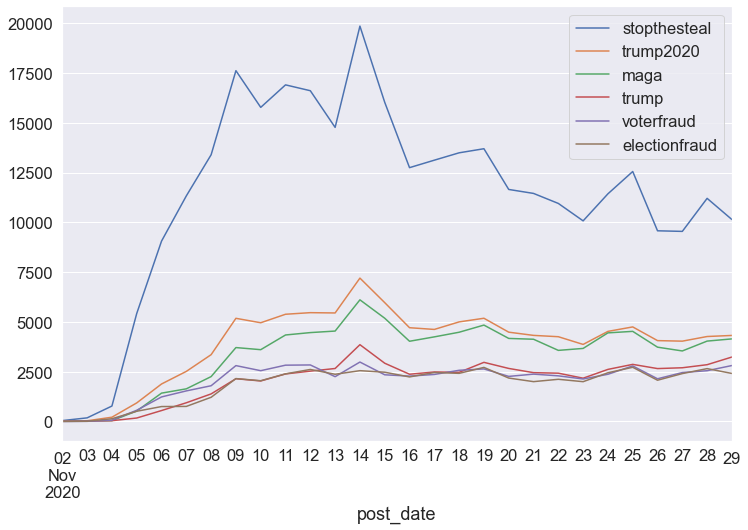

In [441]:
hashtags_to_plot = ['stopthesteal', 'trump2020', 'maga', 'trump', 'voterfraud', 'electionfraud']

frequency_binning = 'D'

res_df = plot_hashtags_over_time(hashtag_data, hashtags_to_plot, frequency_binning)

res_df[res_df.index > '2020-11-01'].plot(figsize=(12,8))

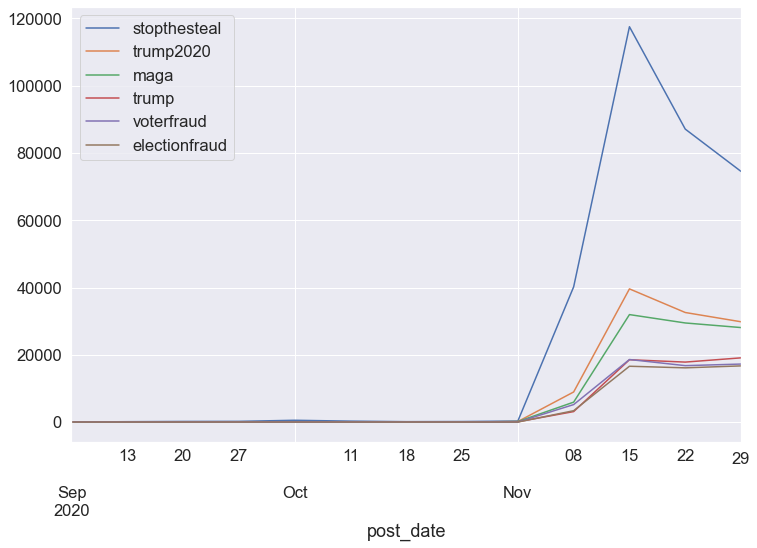

In [445]:
hashtags_to_plot = ['stopthesteal', 'trump2020', 'maga', 'trump', 'voterfraud', 'electionfraud']

frequency_binning = 'W'

res_df = plot_hashtags_over_time(hashtag_data, hashtags_to_plot, frequency_binning)

res_df[res_df.index > '2020-09-01'].plot(figsize=(12,8))

### What are the top hashtags accross time?

In [619]:
hashtag_data.head()

,post_id,creator_id,post_date,hashtag
post_date,,,,
2020-11-29 22:45:19,461b4cc3118142d2958a58ddeaa9f320,d8f57880bbd540e9a1e1bc89e46fdcef,2020-11-29 22:45:19,sleepyjoe
2020-11-29 22:45:19,461b4cc3118142d2958a58ddeaa9f320,d8f57880bbd540e9a1e1bc89e46fdcef,2020-11-29 22:45:19,trumpwon2020
2020-11-29 22:45:19,461b4cc3118142d2958a58ddeaa9f320,d8f57880bbd540e9a1e1bc89e46fdcef,2020-11-29 22:45:19,stopthesteal
2020-11-29 22:45:19,461b4cc3118142d2958a58ddeaa9f320,d8f57880bbd540e9a1e1bc89e46fdcef,2020-11-29 22:45:19,magaagain
2020-11-29 22:45:16,b5c7b951ea1d485db3b490b8f07f56be,5ef511800e6e48d8b23e92d37467b718,2020-11-29 22:45:16,jesusislord


In [674]:
i = 1
start_str = '2020-11-0'+str(i)+' 00:00:00'
end_str = '2020-11-0'+str(i)+' 23:59:59'

series1 = hashtag_data[hashtag_data.post_date.between(start_str, end_str)].groupby('hashtag').size().reset_index(name='occurences').sort_values(by=['occurences'], ascending=False).head(5).reset_index().hashtag

In [675]:
i = 2
start_str = '2020-11-0'+str(i)+' 00:00:00'
end_str = '2020-11-0'+str(i)+' 23:59:59'

series2 = hashtag_data[hashtag_data.post_date.between(start_str, end_str)].groupby('hashtag').size().reset_index(name='occurences').sort_values(by=['occurences'], ascending=False).head(5).reset_index().hashtag

In [691]:
for i in range(1,30):
    if i == 1:
        start_str = '2020-11-0'+str(i)+' 00:00:00'
        end_str = '2020-11-0'+str(i)+' 23:59:59'
        series1 = hashtag_data[hashtag_data.post_date.between(start_str, end_str)].groupby('hashtag').size().reset_index(name='occurences').sort_values(by=['occurences'], ascending=False).head(10).reset_index().hashtag
    elif i == 2:
        start_str = '2020-11-0'+str(i)+' 00:00:00'
        end_str = '2020-11-0'+str(i)+' 23:59:59'
        series2 = hashtag_data[hashtag_data.post_date.between(start_str, end_str)].groupby('hashtag').size().reset_index(name='occurences').sort_values(by=['occurences'], ascending=False).head(10).reset_index().hashtag
        res_df = pd.concat([series1, series2], axis=1, ignore_index=True)
        colnames = ['2020-11-01', '2020-11-02']
    
    elif (i > 2) & (i < 10):
        start_str = '2020-11-0'+str(i)+' 00:00:00'
        end_str = '2020-11-0'+str(i)+' 23:59:59'
        top_5 = hashtag_data[hashtag_data.post_date.between(start_str, end_str)].groupby('hashtag').size().reset_index(name='occurences').sort_values(by=['occurences'], ascending=False).head(10).reset_index().hashtag
        res_df = pd.concat([res_df, top_5], axis=1)
        colnames.append('2020-11-0'+str(i))
    else:
        start_str = '2020-11-'+str(i)+' 00:00:00'
        end_str = '2020-11-'+str(i)+' 23:59:59'
        top_5 = hashtag_data[hashtag_data.post_date.between(start_str, end_str)].groupby('hashtag').size().reset_index(name='occurences').sort_values(by=['occurences'], ascending=False).head(10).reset_index().hashtag
        res_df = pd.concat([res_df, top_5], axis=1)
        colnames.append('2020-11-'+str(i))

In [692]:
res_df.columns = colnames
res_df.head(10)

,2020-11-01,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-07,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-21,2020-11-22,2020-11-23,2020-11-24,2020-11-25,2020-11-26,2020-11-27,2020-11-28,2020-11-29
0,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal,stopthesteal
1,wwg1wga,wwg1wga,walkaway,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020,trump2020
2,walkaway,americafirst,wwg1wga,alllivesmatter,election2020,maga,maga,maga,maga,maga,maga,maga,maga,maga,maga,maga,maga,maga,maga,maga,maga,maga,maga,maga,maga,maga,maga,maga,maga
3,americafirst,walkaway,americafirst,1a,voterfraud,voterfraud,voterfraud,voterfraud,voterfraud,voterfraud,voterfraud,voterfraud,trump,trump,trump,trump,trump,voterfraud,trump,trump,trump,trump,trump,trump,trump,trump,trump,trump,trump
4,trump2020,thegreatawakening,alllivesmatter,electionfraud,maga,election2020,election2020,election2020,election2020,election2020,election2020,electionfraud,electionfraud,election2020,electionfraud,voterfraud,electionfraud,trump,electionfraud,voterfraud,voterfraud,voterfraud,voterfraud,electionfraud,voterfraud,voterfraud,voterfraud,electionfraud,voterfraud
5,thegreatawakening,alllivesmatter,thegreatawakening,usa,electionfraud,wwg1wga,trump,trump,electionfraud,electionfraud,electionfraud,trump,voterfraud,voterfraud,voterfraud,electionfraud,voterfraud,electionfraud,voterfraud,electionfraud,electionfraud,electionfraud,electionfraud,voterfraud,electionfraud,electionfraud,electionfraud,voterfraud,electionfraud
6,alllivesmatter,jexit,jexodus,americafirst,1a,electionfraud,wwg1wga,electionfraud,trump,trump,trump,election2020,election2020,wwg1wga,maga2020,election2020,wwg1wga,trumptrain,election2020,trumptrain,trumptrain,maga2020,wwg1wga,wwg1wga,fightback,maga2020,americafirst,election2020,election2020
7,draintheswamp,blexit,blexit,stopthesteal2020,alllivesmatter,americafirst,kag,wwg1wga,wwg1wga,wwg1wga,wwg1wga,maga2020,maga2020,millionmagamarch,election2020,wwg1wga,election2020,election2020,trumptrain,wwg1wga,election2020,dominion,maga2020,maga2020,election2020,election2020,maga2020,maga2020,maga2020
8,maga,jexodus,jexit,2a,2a,kag,electionfraud,kag,kag,trumptrain,maga2020,wwg1wga,wwg1wga,electionfraud,wwg1wga,trumptrain,maga2020,wwg1wga,wwg1wga,election2020,maga2020,election2020,election2020,election2020,wwg1wga,usa,trumptrain,dominion,americafirst
9,kag,maga2020,election2020,redwave,wethepeople,trump,americafirst,maga2020,trumptrain,kag,kag,trumptrain,trumptrain,kag,millionmagamarch,maga2020,kag,americafirst,maga2020,maga2020,wwg1wga,draintheswamp,fightback,draintheswamp,dominion,americafirst,election2020,draintheswamp,trumptrain


In [738]:
res_df[res_df['2020-11-01']=='joseph'].index.values.astype(int)[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [741]:
res_lol = []

unique_tags = set([item for sublist in res_df.values.tolist() for item in sublist])

for tag in unique_tags:
    
    res_l = []
    res_l.append(tag)
    
    for column in res_df.columns:
        try:
            rank = res_df[res_df[column] == tag].index.values.astype(int)[0]
        except IndexError:
            rank = np.NaN
            
        res_l.append(rank)
    res_lol.append(res_l)

In [745]:
colnames = res_df.columns
colnames = colnames.insert(0, 'hashtag')

ranked_df = pd.DataFrame(res_lol, columns=colnames)

## Exploring mentions

In [491]:
mentions_data.head()

,post_id,creator_id,creator_username,tagged_user_id,tagged_username
0,7dc7522299a046e0b67bc45e0112efe0,11099c81c1ca42f88a977b8d4e5e2336,AlexJonesWins,f1c6851c95c98c2d2af35eec0c9cc635,ali
1,7dc7522299a046e0b67bc45e0112efe0,11099c81c1ca42f88a977b8d4e5e2336,AlexJonesWins,dcdd1dc516c64d7880a54edb37bdb8ef,alexjones
2,07ac00ecbc7f4c47bda5ca417c03ed7b,aedaffa4fff44d7bb44d3784817a6af5,Sparry131,89e43877e52645a1bf8239d8a4fa2ac2,genflynn
3,07ac00ecbc7f4c47bda5ca417c03ed7b,aedaffa4fff44d7bb44d3784817a6af5,Sparry131,fd4eaf2436164605b291ba98e7061d7b,sidneypowell
4,07ac00ecbc7f4c47bda5ca417c03ed7b,aedaffa4fff44d7bb44d3784817a6af5,Sparry131,2ea66900ed69a5005fe51fc8b07a1711,linwood


In [502]:
print('Number of users who mentioned someone:', len(mentions_data.creator_id.unique()))

Number of users who mentioned someone: 6986


In [503]:
print('Number of users who got mentioned:', len(mentions_data.tagged_user_id.unique()))

Number of users who got mentioned: 7801


In [504]:
print('Total unique users who mentioned or got mentioned:', len(mentions_data.creator_id.append(mentions_data.tagged_user_id).unique()))

Total unique users who mentioned or got mentioned: 14198


### Who is mentioning the most?

In [506]:
mentions_data.creator_username.value_counts().head(30)

Reeseysnotsorry               10743
FreeHK2064                     8438
LuxLexAurum                    5889
PresidentElect2Trump2020TB     4216
JorjalexSTOPTHESTEAL           4191
jbctwo11                       3005
USNewswatch                    2587
nwfpolitical                   2037
QANoNWO                        1986
PatriotTears                   1631
NenalovesUSA                   1569
SocialJusticeRanger            1492
777333Anon                     1442
GrandmaPattiA                  1289
CavemanHumor                   1230
truthbetold4u                  1160
LmLwLL                         1106
USNewsWatchMichonLeddy         1106
lakemonstercl                  1006
DavidJFuller2                   919
Ramann2010                      810
Katgarnit                       757
Dimreaper                       672
2020wtf                         659
RightoftheRight                 641
AJGardner                       623
GiGiQ                           563
PeaceMakerSAR               

### Who is being mentioned the most?

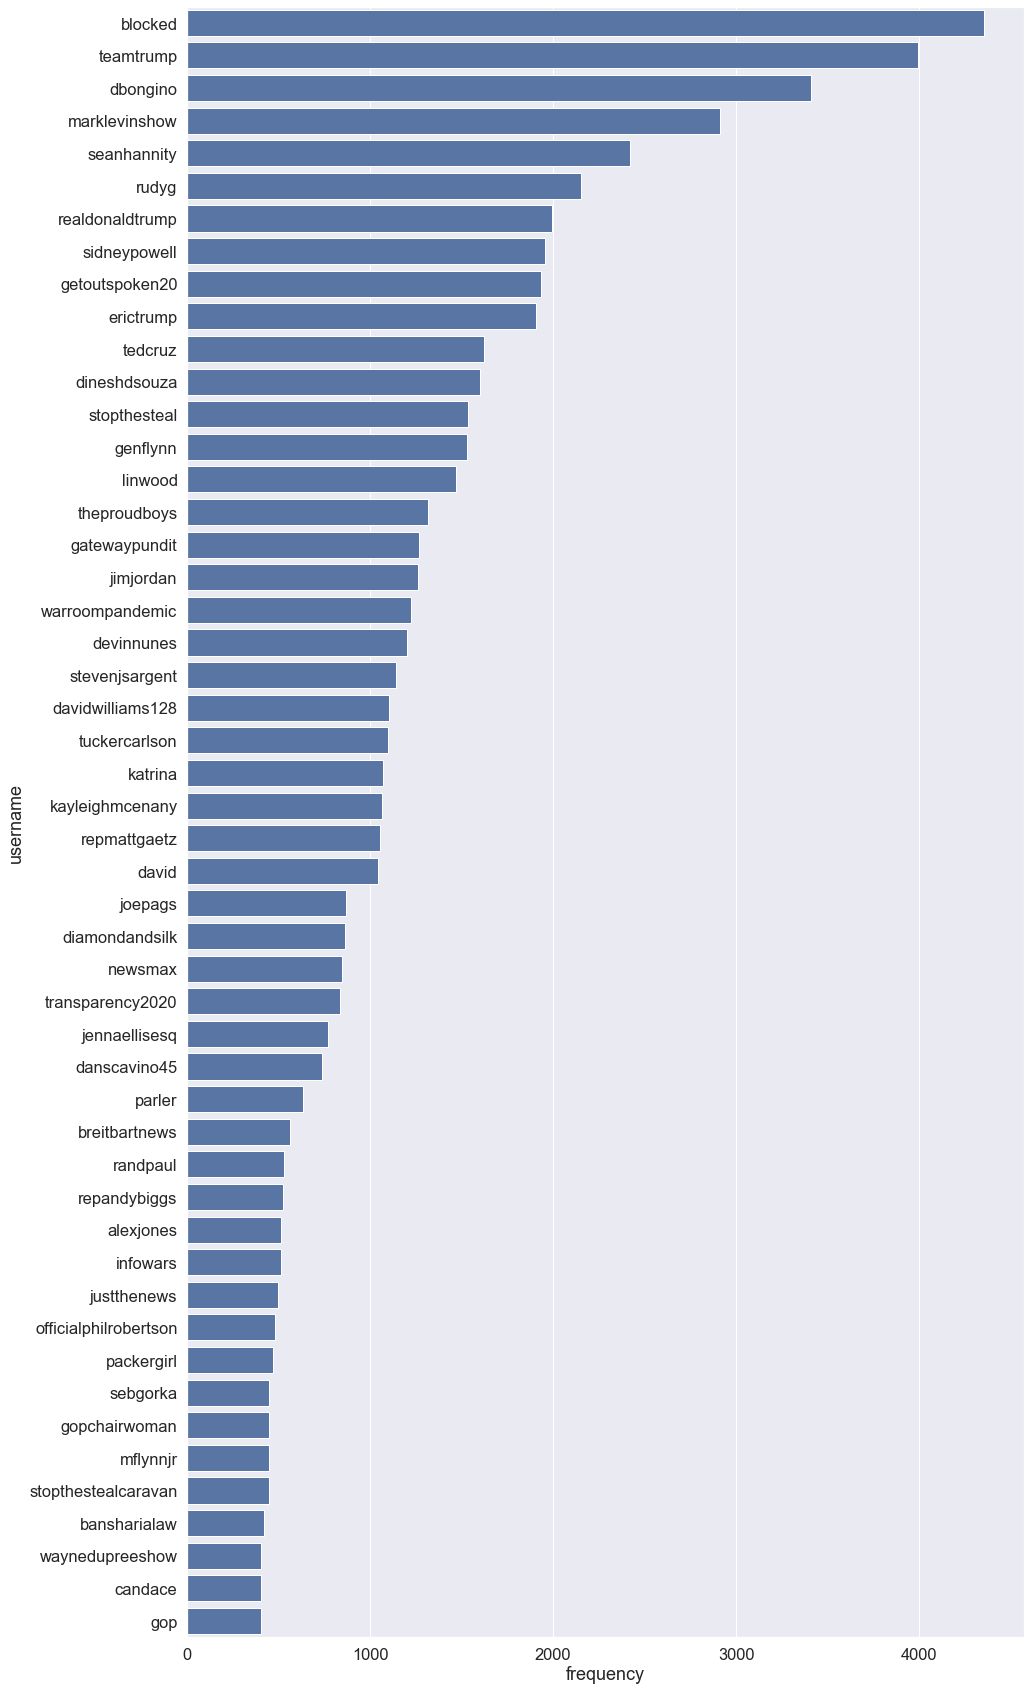

In [512]:
bar_plot_ment = mentions_data['tagged_username'].value_counts().head(50).to_frame()
bar_plot_ment.columns = ['frequency']
bar_plot_ment.index.names = ['username']
bar_plot_ment.reset_index(level=0, inplace=True)

plt.figure(figsize=(15,30))
sns_plot = sns.barplot(y = 'username', x = 'frequency', data = bar_plot_ment, color="b")

In [507]:
mentions_data.tagged_username.value_counts().head(30)

blocked             4356
teamtrump           3995
dbongino            3411
marklevinshow       2914
seanhannity         2421
rudyg               2155
realdonaldtrump     1993
sidneypowell        1955
getoutspoken20      1935
erictrump           1909
tedcruz             1623
dineshdsouza        1601
stopthesteal        1536
genflynn            1527
linwood             1469
theproudboys        1316
gatewaypundit       1265
jimjordan           1262
warroompandemic     1224
devinnunes          1202
stevenjsargent      1139
davidwilliams128    1101
tuckercarlson       1097
katrina             1070
kayleighmcenany     1064
repmattgaetz        1055
david               1044
joepags              869
diamondandsilk       861
newsmax              846
Name: tagged_username, dtype: int64

## exploring links

In [694]:
link_data.head()

,post_id,post_date,creator_id,link_id,createdAt,domain,full_link,type,locale,site_name,state
0,b5c7b951ea1d485db3b490b8f07f56be,2020-11-29 22:45:16,5ef511800e6e48d8b23e92d37467b718,luzWb,2019-07-17 10:01:32,www.youtube.com,https://www.youtube.com/watch?v=CDdY46iAwHI,video.other,NaN,YouTube,VALID
1,fe93a766737745188f5fae4a5339b186,2020-11-29 22:45:13,765cdf14184243259ad5fddb71a854ce,E3NUG,2020-11-29 22:45:13,image-cdn.parler.com,https://image-cdn.parler.com/j/B/jB8D8XSvGC.jpeg,NaN,NaN,NaN,VALID
2,9733b4c526d845679b211d4fc72234ea,2020-11-29 22:44:53,2a5c8defed0648c49c0742a7582ac797,DEnvb,2020-11-25 21:49:39,tumblr,https://mnewstetsfanasf132412.tumblr.com/post/...,photo,NaN,Judge Awards Sasha and Malia Obama’s Biologica...,VALID
3,33b3df15f370463fb281c863a86754c8,2020-11-29 22:44:43,5886183d52694fb5aad2ddc8659fe2a8,im37OJ,2020-11-28 23:12:02,conservativepole.org,http://conservativepole.org/330-2/,NaN,NaN,NaN,VALID
4,af15d2cef2c2490481905454e8365d03,2020-11-29 22:44:25,ba3ef7744e91462f8e5ec15c5001dfd8,ToXwY,2020-11-26 21:34:15,tumblr,https://soro2123.tumblr.com/post/6358809647610...,photo,NaN,List of Soros Politicians ‘Bought and Paid For...,VALID


In [700]:
print('number of posts with links: ', link_data.shape[0])

number of posts with links:  199011


In [699]:
print('number of unique users who have shared a link: ', len(link_data.creator_id.unique()))

number of unique users who have shared a link:  27422


In [701]:
print('number of unique links shared: ', len(link_data.link_id.unique()))

number of unique links shared:  142910


### most shared links

In [708]:
link_data.groupby('full_link').size().reset_index(name='occurences').sort_values(by=['occurences'], ascending=False).head(20).reset_index()[['full_link', 'occurences']]

,full_link,occurences
0,https://rb.gy/9fwfdf,869
1,https://www.digitalwarriorsusa.com,797
2,http://stopthesteal.us,616
3,https://rumble.com/vatvgi-joe-biden-weve-put-t...,550
4,https://www.bitchute.com/video/STZjsXG2tvmV/,510
5,https://www.thegatewaypundit.com/2020/11/huge-...,498
6,https://www.whitehouse.gov/contact/,357
7,https://secure.winred.com/djt/finance-team-dai...,352
8,https://rumble.com/vak7hh-jim-caviezel-nails-i...,351
9,https://ept.ms/DownloadApp,316


In [718]:
link_data[link_data.full_link == 'https://rb.gy/9fwfdf'].tail(10)

,post_id,post_date,creator_id,link_id,createdAt,domain,full_link,type,locale,site_name,state
131860,906e707606454c0c8158130276c2d0a5,2020-11-13 03:15:40,25c6a13e4d4e43b9a1a715d876f05056,tCwP6,2020-11-13 03:12:40,rb.gy,https://rb.gy/9fwfdf,NaN,NaN,NaN,FAILED_STATUS_404
131863,9c061b052294481db59029ee15abe612,2020-11-13 03:15:30,a124d889ca3a4808a33c912808ff0458,tCwP6,2020-11-13 03:12:40,rb.gy,https://rb.gy/9fwfdf,NaN,NaN,NaN,FAILED_STATUS_404
131864,c5ad2aca5b124a7193c9f0400469ee81,2020-11-13 03:15:00,25c6a13e4d4e43b9a1a715d876f05056,tCwP6,2020-11-13 03:12:40,rb.gy,https://rb.gy/9fwfdf,NaN,NaN,NaN,FAILED_STATUS_404
131866,b97919fe9ba848b0a84f51314df00bdd,2020-11-13 03:14:51,a124d889ca3a4808a33c912808ff0458,tCwP6,2020-11-13 03:12:40,rb.gy,https://rb.gy/9fwfdf,NaN,NaN,NaN,FAILED_STATUS_404
131876,828ab05c345b41b58a6fc1343d289944,2020-11-13 03:14:06,25c6a13e4d4e43b9a1a715d876f05056,tCwP6,2020-11-13 03:12:40,rb.gy,https://rb.gy/9fwfdf,NaN,NaN,NaN,FAILED_STATUS_404
131879,9a3e9e4f842a429a91e30938d5fa7d11,2020-11-13 03:13:57,a124d889ca3a4808a33c912808ff0458,tCwP6,2020-11-13 03:12:40,rb.gy,https://rb.gy/9fwfdf,NaN,NaN,NaN,FAILED_STATUS_404
131884,d1b8c829c5f74ebaa8ce153dad4dd0ce,2020-11-13 03:13:30,25c6a13e4d4e43b9a1a715d876f05056,tCwP6,2020-11-13 03:12:40,rb.gy,https://rb.gy/9fwfdf,NaN,NaN,NaN,FAILED_STATUS_404
131887,80557b70d94348b4b53e21530659e05f,2020-11-13 03:13:20,a124d889ca3a4808a33c912808ff0458,tCwP6,2020-11-13 03:12:40,rb.gy,https://rb.gy/9fwfdf,NaN,NaN,NaN,FAILED_STATUS_404
131896,2f7a8b6b578342f895c7512e68827178,2020-11-13 03:13:10,25c6a13e4d4e43b9a1a715d876f05056,tCwP6,2020-11-13 03:12:40,rb.gy,https://rb.gy/9fwfdf,NaN,NaN,NaN,FAILED_STATUS_404
131899,a4a7dc8735e44a55811138299c6f4ee9,2020-11-13 03:12:59,a124d889ca3a4808a33c912808ff0458,tCwP6,2020-11-13 03:12:40,rb.gy,https://rb.gy/9fwfdf,NaN,NaN,NaN,FAILED_STATUS_404


In [721]:
data[data.post_id == 'a4a7dc8735e44a55811138299c6f4ee9']

,post_id,body,post_date,article,depth,links,shareLink,sensitive,parent,root,creator_id,creator_bio,creator_coverPhoto,creator_human,creator_integration,creator_joined,creator_name,creator_rss,creator_profilePhoto,creator_username,creator_verified,creator_verifiedComments,creator_interactions,creator_state,creator_score,hashtags,nr_hashtags,nr_mentions,comments,impressions,reposts,upvotes,creator_badge_0,creator_badge_1,creator_badge_2,creator_badge_3,creator_badge_4,creator_badge_5,creator_badge_6,creator_badge_7,creator_badge_9,nr_links,reputation
209412,a4a7dc8735e44a55811138299c6f4ee9,Want to join TWITTER Alternative??? Check link...,2020-11-13 03:12:59,0.0,0,"[{'_id': 'tCwP6', 'createdAt': '20201113031240...",https://parler.com/post/a4a7dc8735e44a55811138...,False,NaN,NaN,a124d889ca3a4808a33c912808ff0458,NaN,NaN,False,False,2020-11-12 03:19:23,presidentusa,False,NaN,presidentusa,False,False,258,1.0,758,"stopthesteal, recount, election2020, elections...",72,0,0,696,0,1,False,False,False,False,False,False,False,False,False,1,positive


In [725]:
data.iloc[209412].shareLink

'https://parler.com/post/a4a7dc8735e44a55811138299c6f4ee9'

### most shared domains

In [709]:
link_data.groupby('domain').size().reset_index(name='occurences').sort_values(by=['occurences'], ascending=False).head(20).reset_index()[['domain', 'occurences']]

,domain,occurences
0,image-cdn.parler.com,66769
1,@youtube,20778
2,thegatewaypundit.com,11622
3,gnews.org,4166
4,twitter.com,4148
5,@rumblevideo,3659
6,@BreitbartNews,3247
7,www.theepochtimes.com,2942
8,bitchute.com,2914
9,secure.winred.com,1498


In [712]:
link_data[link_data.domain == 'image-cdn.parler.com'].sample(5)

,post_id,post_date,creator_id,link_id,createdAt,domain,full_link,type,locale,site_name,state
46684,ffc3984923e14bb5a15f8d36f96f77db,2020-11-23 06:40:42,12b4b393f0984d13b78fe68b0b70b22c,haIho,2020-11-23 06:39:50,image-cdn.parler.com,https://image-cdn.parler.com/t/r/tr8RKjoNvj.jpeg,NaN,NaN,NaN,VALID
620,edc0aef5d1ca45ce8329c54acdb54021,2020-11-29 21:35:06,dfe3f6db983a400ab3d6682346cafb5e,VpbfD,2020-11-29 21:35:06,image-cdn.parler.com,https://image-cdn.parler.com/h/l/hlQxRvLLcF.jpeg,NaN,NaN,NaN,VALID
119462,41d1c73332a346a4868a2cdc5d7e42e0,2020-11-14 13:16:19,13c0f44e27864af4a0af482ad7f25c49,c4JGC,2020-11-14 13:16:09,image-cdn.parler.com,https://image-cdn.parler.com/v/Y/vYZzu4gaB5.jpeg,NaN,NaN,NaN,VALID
22128,8b4c0d225a614f4d9b868242912e0375,2020-11-26 17:32:31,2498e8df7cbe4b39acaa90afb904145a,Rt4En,2020-11-26 17:31:41,image-cdn.parler.com,https://image-cdn.parler.com/H/s/Hsh9deQuIh.jpeg,NaN,NaN,NaN,VALID
60359,5423e61f11d84aa7a4ca37ab9450aba1,2020-11-21 09:59:01,6a35bba1f6ff40edb5b7cfbb4eb174cc,a96za,2020-11-21 09:59:01,image-cdn.parler.com,https://image-cdn.parler.com/P/N/PN9pCu2cQU.jpeg,NaN,NaN,NaN,VALID


### what are the most shared images

In [715]:
link_data[link_data.domain == 'image-cdn.parler.com'].groupby('full_link').size().reset_index(name='occurences').sort_values(by=['occurences'], ascending=False).head(10).reset_index()[['full_link', 'occurences']]

,full_link,occurences
0,https://image-cdn.parler.com/7/2/72vkcO2GgD.jpeg,25
1,https://image-cdn.parler.com/P/3/P30Fg8d6kc.jpeg,24
2,https://image-cdn.parler.com/K/D/KD4DQOb26W.jpeg,17
3,https://image-cdn.parler.com/G/Z/GZ53xBt28V.png,13
4,https://image-cdn.parler.com/T/e/TeBl547xGf.jpeg,13
5,https://image-cdn.parler.com/O/S/OSbHkIpfhp.jpeg,13
6,https://image-cdn.parler.com/x/s/xsK1teMHjo.jpeg,12
7,https://image-cdn.parler.com/7/f/7fj2OSup49.jpeg,12
8,https://image-cdn.parler.com/f/f/ff7KFIg9Uf.jpeg,8
9,https://image-cdn.parler.com/w/I/wInldBr1x8.jpeg,8


### what are the most shared youtube links?

In [716]:
link_data[link_data.domain == '@youtube'].groupby('full_link').size().reset_index(name='occurences').sort_values(by=['occurences'], ascending=False).head(10).reset_index()[['full_link', 'occurences']]

,full_link,occurences
0,https://youtu.be/-9yM8d3koX8,188
1,https://youtu.be/kSNIkUt_VyY,186
2,https://youtu.be/tGl4V5rc3GQ,119
3,https://youtu.be/whUGwjpc00U,118
4,https://youtu.be/R5pbtRoZ7w8,96
5,https://youtu.be/0RsTnQPpLWU,84
6,https://youtu.be/Ztu5Y5obWPk,82
7,https://youtu.be/DSDZkXxFVEU,76
8,https://youtu.be/WjVxoKiEU_k,75
9,https://youtu.be/PJEIBCPTm_c,73


### exploring other columns

In [695]:
link_data.state.value_counts()

VALID                191861
FAILED_STATUS_404      2317
FAILED                 1437
FAILED_STATUS_403       674
FAILED_STATUS_503       621
FAILED_STATUS_429       392
FAILED_STATUS_502       219
VIDEO_PROCESSING        213
FAILED_STATUS_405       147
FAILED_STATUS_400       113
FAILED_STATUS_500        26
FAILED_STATUS_401        10
FAILED_STATUS_501         8
FAILED_STATUS_410         7
FAILED_STATUS_520         6
FAILED_STATUS_417         6
FAILED_STATUS_504         4
FAILED_STATUS_505         4
FAILED_STATUS_508         2
FAILED_STATUS_999         2
Name: state, dtype: int64

In [696]:
link_data.locale.value_counts()

en_US         46060
en_GB           294
en_gb           217
en_us           131
en              126
en-US            16
en-gb             9
es_ES             9
fr_FR             8
ar_AR             8
sr_RS             7
fr                7
zh_TW             7
zh_CN             5
de_DE             4
en_CA             3
en_IN             3
en_NZ             3
it_IT             2
pt_BR             2
nl_NL             1
de                1
RT Deutsch        1
ja_JP             1
el_GR             1
en_ES             1
Name: locale, dtype: int64

In [698]:
link_data.type.value_counts().head(20)

article                           57753
youtube                           20780
video.other                        8273
website                            7622
video                               857
conservative digital activists      797
video.movie                         606
photo                               585
change-org:petition                 400
product                             201
profile                             136
video/mp4                           102
image/jpeg                           93
music.radio_station                  77
events.event                         74
music.song                           54
scribd-com:document                  40
product.item                         36
image                                26
product.group                        25
Name: type, dtype: int64